In [1]:
# AeroCNN-II with U-Net
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import logging
from tensorflow.python.client import device_lib

import datetime
%matplotlib inline

In [ ]:
logger = logging.getLogger("20221012AirfoilFlowFieldPrediction(AeroCNN-II)(50kernels, 5x5, stride1, 2CNNlayer)(test 0.05)(UNetApplied)")
formatter = logging.Formatter('[%(asctime)s][%(levelname)s|%(filename)s:%(lineno)s] >> %(message)s')

In [ ]:
streamHandler = logging.StreamHandler()
fileHandler = logging.FileHandler('D:\\AeroCNN-II_logs\\20221012AirfoilFlowFieldPrediction(AeroCNN-II)(50kernels, 5x5, stride1, 2CNNlayer)(test 0.05)(UNetApplied).log')

logger.addHandler(streamHandler)
logger.addHandler(fileHandler)

In [ ]:
logger.setLevel(level=logging.DEBUG)
logger.debug('my DEBUG log')
logger.info('my INFO log')
logger.warning('my WARNING log')
logger.error('my ERROR log')
logger.critical('my CRITICAL log')

In [2]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 651852821571809066
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 22722641920
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17308903685207871857
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419,
 name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 22722641920
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4506316647510337352
 physical_device_desc: "device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:41:00.0, compute capability: 8.6"
 xla_global_id: 2144165316,
 name: "/device:GPU:2"
 device_type: "GPU"
 memory_limit: 22722641920
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12949284819657263010
 physical_device_desc: "device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:61:00.0, compute capability: 8.6"
 xla_global_

In [3]:
mirrored_strategy = tf.distribute.MirroredStrategy(["/GPU:0","/GPU:1","/GPU:2"], cross_device_ops = tf.distribute.HierarchicalCopyAllReduce())

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


In [4]:
n_kernel=50
l2Regularizer=1e-09
kernel_size1 = 5
kernel_size2 = 5
#kernel_size3 = 5
n_grid = 101
strides = 1
input_size = 100

In [5]:
alpha = np.linspace(-10,20,16).reshape((16,1))

In [6]:
aa = np.zeros((16*133,1))
for i in range(0, 133):
    aa[16*i:16*(i+1), :] = alpha[:,:]

In [7]:
aa = aa.reshape((133, 16, 1, 1))

In [8]:
os.chdir('D:\\AeroCNN2Inputs')

In [9]:
origin = "D:\\AeroCNN2Inputs"
origin_data = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"
origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"

In [10]:
folders_orig = os.listdir(origin)
folders = [file for file in folders_orig if file.endswith('.csv')]

In [11]:
image_df = pd.DataFrame()
for i in range(1, 134):
    for j in range(0, alpha.shape[0]):
        csv_file_name = origin + '\\airfoil' + str(i) + "_alpha"+ str(int(alpha[j])) + ".csv"
        data = pd.read_csv(csv_file_name, header=None)
        image_df = pd.concat([image_df, data], axis=0)

In [12]:
image_np = image_df.iloc[:, :].values

In [13]:
image = image_np.reshape((133, 16, 100, 100))

In [14]:
image = 1-image/100

In [15]:
path = 'D:\\airfoilFlowField'
file_list = os.listdir(path)
file_list_py = [file for file in file_list if file.endswith('.csv')]

In [16]:
file_name = origin_data + "\\AirfoilIndexList.xlsx"
airfoilName_df = pd.read_excel(file_name)
geometry_orig = airfoilName_df.iloc[:, 0].values

In [17]:
data_name = path + '\\' + str(geometry_orig[0]) + "alpha"+ str(int(alpha[1])) + "_interpolated.csv"
print(data_name)

D:\airfoilFlowField\airfoil1alpha-8_interpolated.csv


In [18]:
Vmag_df = pd.DataFrame()
for i in range(1, 134):
    for j in range(0, alpha.shape[0]):
        data_name = path + '\\' + str(geometry_orig[i-1]) + "alpha"+ str(int(alpha[j])) + "_interpolated.csv"
        data = pd.read_csv(data_name, header=None)
        Vmag_df = pd.concat([Vmag_df, data], axis=0)

In [19]:
geometry_orig = airfoilName_df.iloc[:, 1].values

In [20]:
y_imp = Vmag_df.iloc[:, :].values

In [21]:
y = y_imp.reshape((133, 16, n_grid, n_grid))

In [22]:
geometry = np.zeros((133*16,1))
geometry = geometry.astype(np.string_)
for i in geometry_orig:
    index_ = np.where(geometry_orig==i)
    for j in range(0,16):
        geometry[16*index_[0]+j,:] = np.asarray(i)

In [23]:
geometry.shape

(2128, 1)

In [24]:
geometry = geometry.reshape((133, 16, 1))

In [25]:
x_train, x_test, aa_train, aa_test, geo_train, geo_test, y_train, y_test = train_test_split(image, aa, geometry, y, test_size=0.05, random_state=1)

In [26]:
x_train = x_train.reshape((x_train.shape[0]*x_train.shape[1], x_train.shape[2], x_train.shape[3], 1))
x_test = x_test.reshape((x_test.shape[0]*x_test.shape[1], x_test.shape[2], x_test.shape[3], 1))
aa_train = aa_train.reshape((aa_train.shape[0]*aa_train.shape[1], aa_train.shape[2], aa_train.shape[3]))
aa_test = aa_test.reshape((aa_test.shape[0]*aa_test.shape[1], aa_test.shape[2], aa_test.shape[3]))
geo_train = geo_train.reshape((geo_train.shape[0]*geo_train.shape[1], geo_train.shape[2]))
geo_test = geo_test.reshape((geo_test.shape[0]*geo_test.shape[1], geo_test.shape[2]))
y_train = y_train.reshape((y_train.shape[0]*y_train.shape[1], y_train.shape[2], y_train.shape[3]))
y_test = y_test.reshape((y_test.shape[0]*y_test.shape[1], y_test.shape[2], y_test.shape[3]))

In [27]:
with mirrored_strategy.scope():
    input_image = tf.keras.Input(shape=(input_size, input_size, 1))

    x_conv_E = tf.keras.layers.Conv2D(n_kernel, (kernel_size1, kernel_size1), strides=(strides, strides),
                                      activation='relu', padding='same',
                                      kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer),
                                      name='Conv2DLayer1')(input_image)
    x_pool_E = tf.keras.layers.MaxPooling2D((2,2))(x_conv_E)

    x_conv_D = tf.keras.layers.Conv2DTranspose(n_kernel, (kernel_size1, kernel_size1), strides = (2, 2),
                                         padding='same', activation='relu')(x_pool_E)
    x_concat = tf.concat([x_conv_E, x_conv_D], axis=-1)
    x_conv_Final = tf.keras.layers.Conv2D(1, (kernel_size1, kernel_size1), strides=(strides, strides),
                                          activation='relu', padding='same',
                                          kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer),
                                          name='Conv2DLayer2')(x_concat)
    reshape1 = tf.keras.layers.Flatten()(x_conv_Final)
    x_ = tf.keras.layers.Dense(units=n_grid*n_grid, activation=None, name='outputLayer',
                               kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer))(reshape1)

    output_image = tf.keras.layers.Reshape((n_grid, n_grid, 1))(x_)
    # AeroCNN-II based
    model = tf.keras.Model(input_image, output_image)

In [28]:
with mirrored_strategy.scope():
    model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 1  0           []                               
                                )]                                                                
                                                                                                  
 Conv2DLayer1 (Conv2D)          (None, 100, 100, 50  1300        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 50, 50, 50)   0           ['Conv2DLayer1[0][0]']           
                                                                                              

In [29]:
with mirrored_strategy.scope():
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss = tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [30]:
with mirrored_strategy.scope():
    start = datetime.datetime.now()
    history = model.fit(x_train, y_train, epochs=5000, shuffle=True,callbacks=tf.keras.callbacks.EarlyStopping(monitor='loss', patience=30))
    end = datetime.datetime.now()

Epoch 1/5000
INFO:tensorflow:batch_all_reduce: 8 all-reduces with algorithm = hierarchical_copy, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 8 all-reduces with algorithm = hierarchical_copy, num_packs = 1
63/63 [==============================] - 19s 130ms/step - loss: 2.7380 - rmse: 1.6547
Epoch 2/5000
63/63 [==============================] - 8s 130ms/step - loss: 0.1480 - rmse: 0.3847
Epoch 3/5000
63/63 [==============================] - 8s 133ms/step - loss: 0.1462 - rmse: 0.3823
Epoch 4/5000
63/63 [==============================] - 8s 134ms/step - loss: 0.1462 - rmse: 0.3824
Epoch 5/5000
63/63 [==============================] - 8s 133ms/step - loss: 0.1444 - rmse: 0.3800
Epoch 6/5000
63/63 [=============

63/63 [==============================] - 8s 131ms/step - loss: 0.0301 - rmse: 0.1735
Epoch 80/5000
63/63 [==============================] - 8s 133ms/step - loss: 0.0307 - rmse: 0.1752
Epoch 81/5000
63/63 [==============================] - 8s 133ms/step - loss: 0.0313 - rmse: 0.1770
Epoch 82/5000
63/63 [==============================] - 8s 131ms/step - loss: 0.0323 - rmse: 0.1796
Epoch 83/5000
63/63 [==============================] - 8s 129ms/step - loss: 0.0309 - rmse: 0.1758
Epoch 84/5000
63/63 [==============================] - 8s 129ms/step - loss: 0.0292 - rmse: 0.1708
Epoch 85/5000
63/63 [==============================] - 8s 129ms/step - loss: 0.0301 - rmse: 0.1733
Epoch 86/5000
63/63 [==============================] - 8s 129ms/step - loss: 0.0338 - rmse: 0.1837
Epoch 87/5000
63/63 [==============================] - 8s 131ms/step - loss: 0.0295 - rmse: 0.1717
Epoch 88/5000
63/63 [==============================] - 8s 130ms/step - loss: 0.0308 - rmse: 0.1755
Epoch 89/5000
63/63 [===

63/63 [==============================] - 8s 131ms/step - loss: 0.0203 - rmse: 0.1422
Epoch 244/5000
63/63 [==============================] - 8s 131ms/step - loss: 0.0201 - rmse: 0.1417
Epoch 245/5000
63/63 [==============================] - 8s 132ms/step - loss: 0.0199 - rmse: 0.1410
Epoch 246/5000
63/63 [==============================] - 8s 131ms/step - loss: 0.0200 - rmse: 0.1412
Epoch 247/5000
63/63 [==============================] - 8s 130ms/step - loss: 0.0200 - rmse: 0.1413
Epoch 248/5000
63/63 [==============================] - 8s 129ms/step - loss: 0.0198 - rmse: 0.1404
Epoch 249/5000
63/63 [==============================] - 8s 129ms/step - loss: 0.0202 - rmse: 0.1418
Epoch 250/5000
63/63 [==============================] - 8s 130ms/step - loss: 0.0198 - rmse: 0.1404
Epoch 251/5000
63/63 [==============================] - 8s 130ms/step - loss: 0.0199 - rmse: 0.1408
Epoch 252/5000
63/63 [==============================] - 8s 130ms/step - loss: 0.0204 - rmse: 0.1426
Epoch 253/5000


63/63 [==============================] - 8s 129ms/step - loss: 0.0170 - rmse: 0.1300
Epoch 326/5000
63/63 [==============================] - 8s 131ms/step - loss: 0.0170 - rmse: 0.1300
Epoch 327/5000
63/63 [==============================] - 8s 131ms/step - loss: 0.0171 - rmse: 0.1306
Epoch 328/5000
63/63 [==============================] - 8s 130ms/step - loss: 0.0169 - rmse: 0.1297
Epoch 329/5000
63/63 [==============================] - 8s 131ms/step - loss: 0.0171 - rmse: 0.1307
Epoch 330/5000
63/63 [==============================] - 8s 131ms/step - loss: 0.0168 - rmse: 0.1293
Epoch 331/5000
63/63 [==============================] - 8s 131ms/step - loss: 0.0170 - rmse: 0.1302
Epoch 332/5000
63/63 [==============================] - 8s 132ms/step - loss: 0.0168 - rmse: 0.1292
Epoch 333/5000
63/63 [==============================] - 8s 131ms/step - loss: 0.0168 - rmse: 0.1294
Epoch 334/5000
63/63 [==============================] - 8s 133ms/step - loss: 0.0167 - rmse: 0.1291
Epoch 335/5000


63/63 [==============================] - 8s 130ms/step - loss: 0.0146 - rmse: 0.1204
Epoch 408/5000
63/63 [==============================] - 8s 130ms/step - loss: 0.0146 - rmse: 0.1204
Epoch 409/5000
63/63 [==============================] - 8s 130ms/step - loss: 0.0147 - rmse: 0.1211
Epoch 410/5000
63/63 [==============================] - 8s 132ms/step - loss: 0.0145 - rmse: 0.1199
Epoch 411/5000
63/63 [==============================] - 8s 130ms/step - loss: 0.0146 - rmse: 0.1205
Epoch 412/5000
63/63 [==============================] - 8s 130ms/step - loss: 0.0145 - rmse: 0.1200
Epoch 413/5000
63/63 [==============================] - 8s 130ms/step - loss: 0.0145 - rmse: 0.1201
Epoch 414/5000
63/63 [==============================] - 8s 130ms/step - loss: 0.0141 - rmse: 0.1185
Epoch 415/5000
63/63 [==============================] - 8s 130ms/step - loss: 0.0146 - rmse: 0.1207
Epoch 416/5000
63/63 [==============================] - 8s 130ms/step - loss: 0.0144 - rmse: 0.1197
Epoch 417/5000


63/63 [==============================] - 8s 130ms/step - loss: 0.0129 - rmse: 0.1131
Epoch 490/5000
63/63 [==============================] - 8s 130ms/step - loss: 0.0127 - rmse: 0.1123
Epoch 491/5000
63/63 [==============================] - 8s 129ms/step - loss: 0.0127 - rmse: 0.1122
Epoch 492/5000
63/63 [==============================] - 8s 129ms/step - loss: 0.0127 - rmse: 0.1125
Epoch 493/5000
63/63 [==============================] - 8s 129ms/step - loss: 0.0126 - rmse: 0.1120
Epoch 494/5000
63/63 [==============================] - 8s 130ms/step - loss: 0.0128 - rmse: 0.1129
Epoch 495/5000
63/63 [==============================] - 8s 130ms/step - loss: 0.0126 - rmse: 0.1120
Epoch 496/5000
63/63 [==============================] - 8s 131ms/step - loss: 0.0128 - rmse: 0.1127
Epoch 497/5000
63/63 [==============================] - 8s 130ms/step - loss: 0.0126 - rmse: 0.1117
Epoch 498/5000
63/63 [==============================] - 8s 131ms/step - loss: 0.0124 - rmse: 0.1110
Epoch 499/5000


63/63 [==============================] - 8s 130ms/step - loss: 0.0110 - rmse: 0.1045
Epoch 572/5000
63/63 [==============================] - 8s 132ms/step - loss: 0.0114 - rmse: 0.1063
Epoch 573/5000
63/63 [==============================] - 8s 131ms/step - loss: 0.0113 - rmse: 0.1061
Epoch 574/5000
63/63 [==============================] - 8s 133ms/step - loss: 0.0116 - rmse: 0.1071
Epoch 575/5000
63/63 [==============================] - 8s 131ms/step - loss: 0.0112 - rmse: 0.1056
Epoch 576/5000
63/63 [==============================] - 8s 132ms/step - loss: 0.0111 - rmse: 0.1051
Epoch 577/5000
63/63 [==============================] - 8s 129ms/step - loss: 0.0115 - rmse: 0.1069
Epoch 578/5000
63/63 [==============================] - 8s 129ms/step - loss: 0.0111 - rmse: 0.1050
Epoch 579/5000
63/63 [==============================] - 8s 129ms/step - loss: 0.0111 - rmse: 0.1051
Epoch 580/5000
63/63 [==============================] - 8s 129ms/step - loss: 0.0108 - rmse: 0.1034
Epoch 581/5000


63/63 [==============================] - 8s 130ms/step - loss: 0.0103 - rmse: 0.1011
Epoch 654/5000
63/63 [==============================] - 8s 129ms/step - loss: 0.0099 - rmse: 0.0990
Epoch 655/5000
63/63 [==============================] - 8s 129ms/step - loss: 0.0099 - rmse: 0.0989
Epoch 656/5000
63/63 [==============================] - 8s 130ms/step - loss: 0.0097 - rmse: 0.0979
Epoch 657/5000
63/63 [==============================] - 8s 129ms/step - loss: 0.0098 - rmse: 0.0988
Epoch 658/5000
63/63 [==============================] - 8s 129ms/step - loss: 0.0099 - rmse: 0.0993
Epoch 659/5000
63/63 [==============================] - 8s 130ms/step - loss: 0.0099 - rmse: 0.0989
Epoch 660/5000
63/63 [==============================] - 8s 130ms/step - loss: 0.0098 - rmse: 0.0986
Epoch 661/5000
63/63 [==============================] - 8s 130ms/step - loss: 0.0099 - rmse: 0.0990
Epoch 662/5000
63/63 [==============================] - 8s 130ms/step - loss: 0.0097 - rmse: 0.0980
Epoch 663/5000


63/63 [==============================] - 8s 130ms/step - loss: 0.0096 - rmse: 0.0976
Epoch 736/5000
63/63 [==============================] - 8s 130ms/step - loss: 0.0092 - rmse: 0.0954
Epoch 737/5000
63/63 [==============================] - 8s 130ms/step - loss: 0.0093 - rmse: 0.0960
Epoch 738/5000
63/63 [==============================] - 8s 130ms/step - loss: 0.0088 - rmse: 0.0935
Epoch 739/5000
63/63 [==============================] - 8s 130ms/step - loss: 0.0091 - rmse: 0.0952
Epoch 740/5000
63/63 [==============================] - 8s 131ms/step - loss: 0.0089 - rmse: 0.0940
Epoch 741/5000
63/63 [==============================] - 8s 131ms/step - loss: 0.0092 - rmse: 0.0956
Epoch 742/5000
63/63 [==============================] - 8s 130ms/step - loss: 0.0090 - rmse: 0.0944
Epoch 743/5000
63/63 [==============================] - 8s 131ms/step - loss: 0.0090 - rmse: 0.0944
Epoch 744/5000
63/63 [==============================] - 8s 129ms/step - loss: 0.0093 - rmse: 0.0959
Epoch 745/5000


63/63 [==============================] - 8s 132ms/step - loss: 0.0087 - rmse: 0.0930
Epoch 818/5000
63/63 [==============================] - 8s 131ms/step - loss: 0.0085 - rmse: 0.0915
Epoch 819/5000
63/63 [==============================] - 8s 130ms/step - loss: 0.0087 - rmse: 0.0929
Epoch 820/5000
63/63 [==============================] - 8s 129ms/step - loss: 0.0087 - rmse: 0.0930
Epoch 821/5000
63/63 [==============================] - 8s 130ms/step - loss: 0.0084 - rmse: 0.0910
Epoch 822/5000
63/63 [==============================] - 8s 130ms/step - loss: 0.0086 - rmse: 0.0923
Epoch 823/5000
63/63 [==============================] - 8s 131ms/step - loss: 0.0084 - rmse: 0.0912
Epoch 824/5000
63/63 [==============================] - 8s 131ms/step - loss: 0.0083 - rmse: 0.0906


In [31]:
time = end - start
print("Training time:", time)

Training time: 1:53:38.205405


In [ ]:
os.chdir("D:\\AeroCNNII_Images")

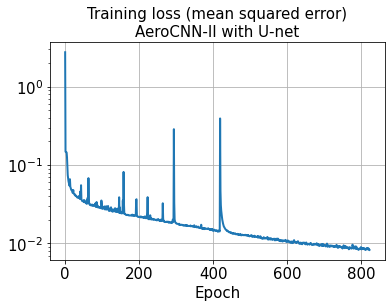

In [32]:
hist = history.history
plt.plot(hist['loss'], lw=2)
plt.title('Training loss (mean squared error)\nAeroCNN-II with U-net', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.savefig("20221012AeroCNNIIwithUnet(2CNNlayer)(Trainingloss).jpg", dpi=300)
plt.show()

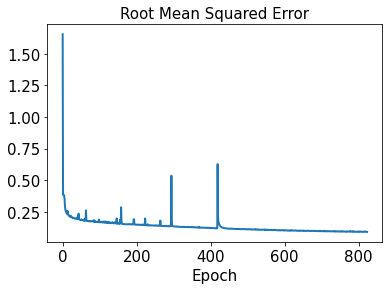

In [33]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

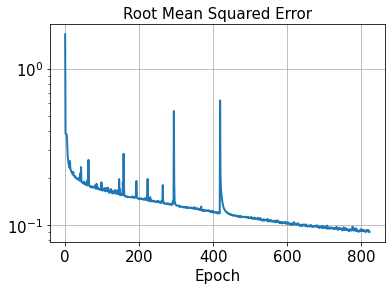

In [34]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.savefig("20221012AeroCNNIIwithUnet(2CNNlayer)(RMSE).jpg", dpi=300)
plt.show()

In [35]:
with mirrored_strategy.scope():
    test_results = model.evaluate(x_train)
    decoded_train = model.predict(x_train)
    decoded_test = model.predict(x_test)

4/4 [==============================] - 0s 23ms/step


In [36]:
test_results2 = model.evaluate(x_test)

4/4 [==============================] - 0s 7ms/step - loss: 7.8404e-05 - rmse: 0.0000e+00


In [37]:
y_train.shape

(2016, 101, 101)

In [38]:
y_train.shape[0]

2016

In [39]:
type(decoded_train.shape[3])

int

In [40]:
type(decoded_train)

numpy.ndarray

In [41]:
type(n_grid)

int

In [42]:
decoded_train = decoded_train.reshape((int(y_train.shape[0]),int(n_grid),int(n_grid)))
decoded_test = decoded_test.reshape((int(y_test.shape[0]),int(n_grid),int(n_grid)))

In [43]:
decoded_train.shape

(2016, 101, 101)

In [44]:
y_train.shape[0]

2016

In [45]:
error_train_abs = np.abs(decoded_train - y_train)

In [46]:
error_test_abs = np.abs(decoded_test - y_test)

In [47]:
error_train_Cl_abs = np.abs(decoded_train[:,0,:] - y_train[:,0,:])

In [48]:
error_train_Cd_abs = np.abs(decoded_train[:,1,:] - y_train[:,1,:])

In [49]:
error_test_Cl_abs = np.abs(decoded_test[:,0,:] - y_test[:,0,:])

In [50]:
error_test_Cd_abs = np.abs(decoded_test[:,1,:] - y_test[:,1,:])

In [51]:
decoded_train.shape

(2016, 101, 101)

In [52]:
os.chdir("D:\\TrainedModels")

In [53]:
os.chdir("D:\\TrainedModels\\20221012")
model.save('AeroCNN-II_with_U-net_FlowFieldPrediction_50kernel_2by2MaxPooling_1CNNlayer_testSize0.05.h5',
           overwrite=True, include_optimizer=True, save_format='h5')

In [54]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

0.017313588474028196


In [55]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

0.03562907114505256


In [56]:
l2_error_train_list = []
for i in range(0, len(aa_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum(y_train[i]**2))
    l2_error_train_list.append(l2_error_train_data)
#print(l2_error_train_list)

[0.013199186550845723, 0.013767412295366831, 0.014553856202908916, 0.010417202486797334, 0.008725586012961879, 0.008780391136510118, 0.01010439139533312, 0.010982114099619413, 0.01326792737518765, 0.015582420824456286, 0.023288973022726533, 0.011075064612990553, 0.013769409440660825, 0.013218700834307979, 0.028398467960517995, 0.030191025345641196, 0.019431198856239375, 0.008649087315595036, 0.009877930811375118, 0.010247365378654416, 0.010228504097259443, 0.010961237428590209, 0.010901230001462252, 0.010984779136499579, 0.010726830006039464, 0.010326356618980282, 0.02240723191811274, 0.013776089337187703, 0.013245001344300698, 0.05114589084220848, 0.04247538431321272, 0.039271734308610584, 0.013960921513612709, 0.02224297263949901, 0.011637875052465824, 0.012028085249737757, 0.011972477716788572, 0.013634814519796515, 0.01339473202213714, 0.013381692497718171, 0.012247895476794297, 0.013504084097867202, 0.015192331308282537, 0.020734552747219772, 0.019351686990236806, 0.03773906003902

In [57]:
l2_error_test_list = []
for i in range(0, len(aa_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum(y_test[i]**2))
    l2_error_test_list.append(l2_error_test_data)
#print(l2_error_test_list)

[0.015039820009868556, 0.013461341976027445, 0.008870084370721657, 0.010488494982527312, 0.0092018638326414, 0.008158387573707243, 0.009344101446591736, 0.009733340502131814, 0.009594208347953869, 0.012447983820410544, 0.04530289386034501, 0.015978714694099158, 0.0208682879420624, 0.03761125233918923, 0.06468411583526834, 0.07055638433942148, 0.019656098881597056, 0.019689301448660552, 0.018394880566236817, 0.01851764174843753, 0.019588549458918376, 0.01661756470108499, 0.016379726883196583, 0.016400248731061797, 0.01683477500963615, 0.01872333688695426, 0.019343435687962155, 0.023369099187920617, 0.025563024646591256, 0.028615834412107386, 0.06487126714575239, 0.10462471159051698, 0.016500622555678714, 0.012922565328005871, 0.009731779455957412, 0.0101201027997359, 0.011747498043822796, 0.010640573538449391, 0.01248124786813219, 0.012872872136269139, 0.010993068147271905, 0.012705480227211815, 0.04371779871911218, 0.0181174460654976, 0.07733962778757864, 0.07839424281424218, 0.0346625

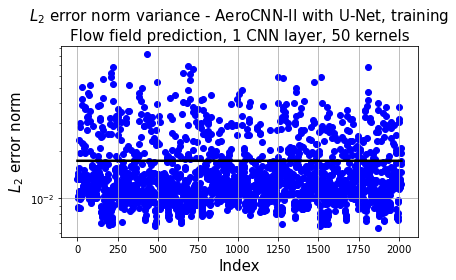

In [58]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-II with U-Net, training\nFlow field prediction, 2 CNN layer, 50 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.savefig("D:\\AeroCNNII_Images\\20221012AeroCNNIIwithUnet(2CNNlayer)(trainingeErrorDistribution).png")
plt.show()

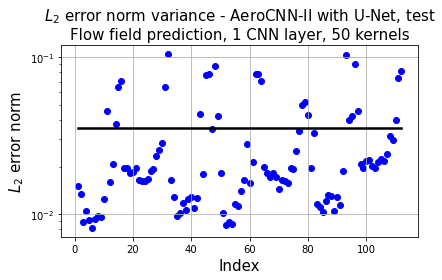

In [59]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-II with U-Net, test\nFlow field prediction, 2 CNN layer, 50 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.savefig("20221012AeroCNNIIwithUnet(2CNNlayer)(testErrorDistribution)")
plt.show()

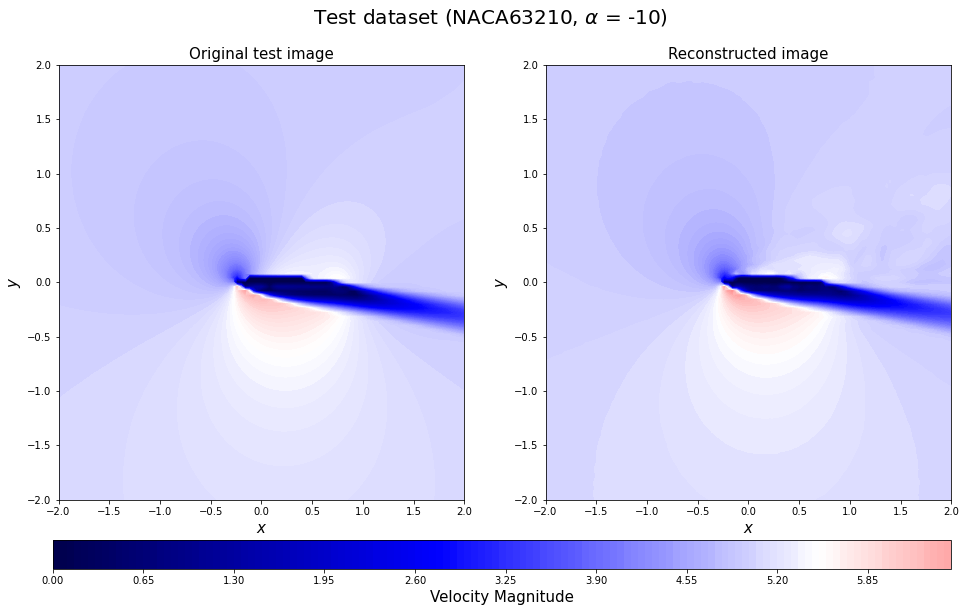

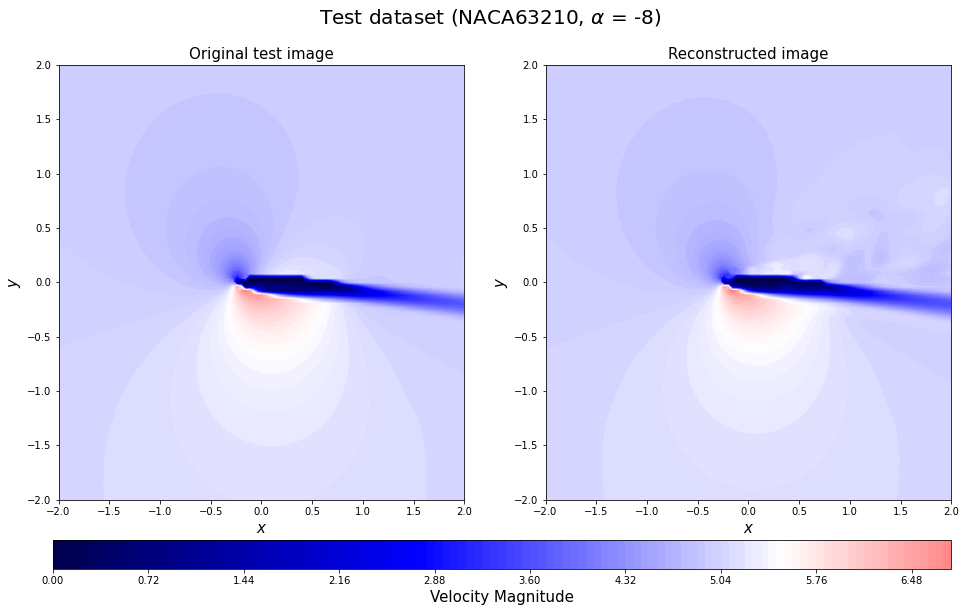

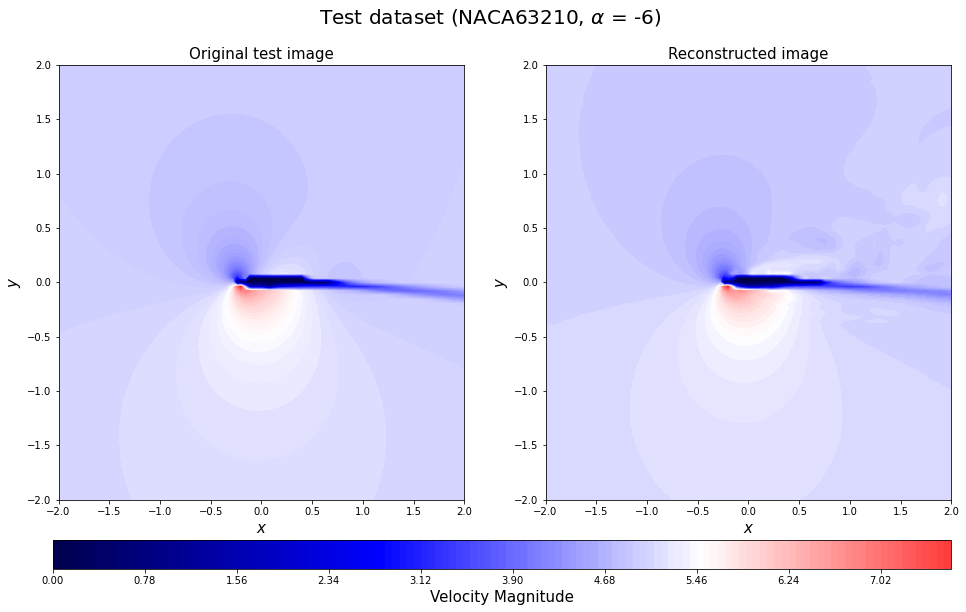

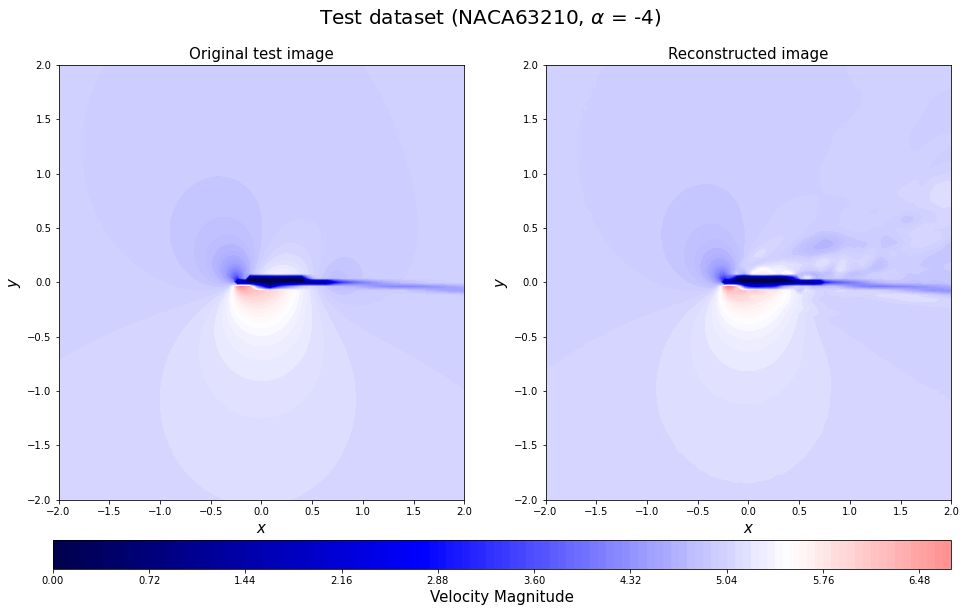

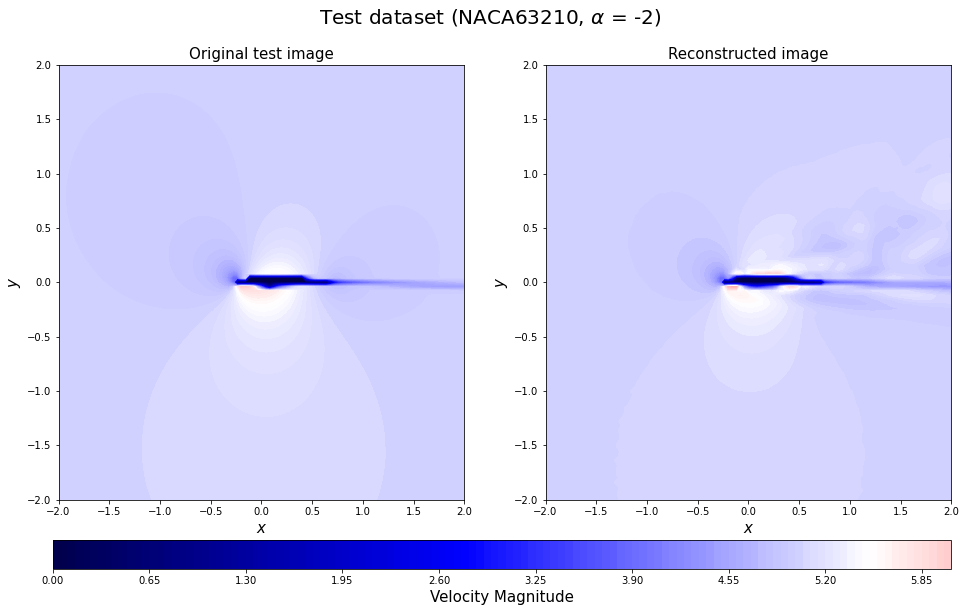

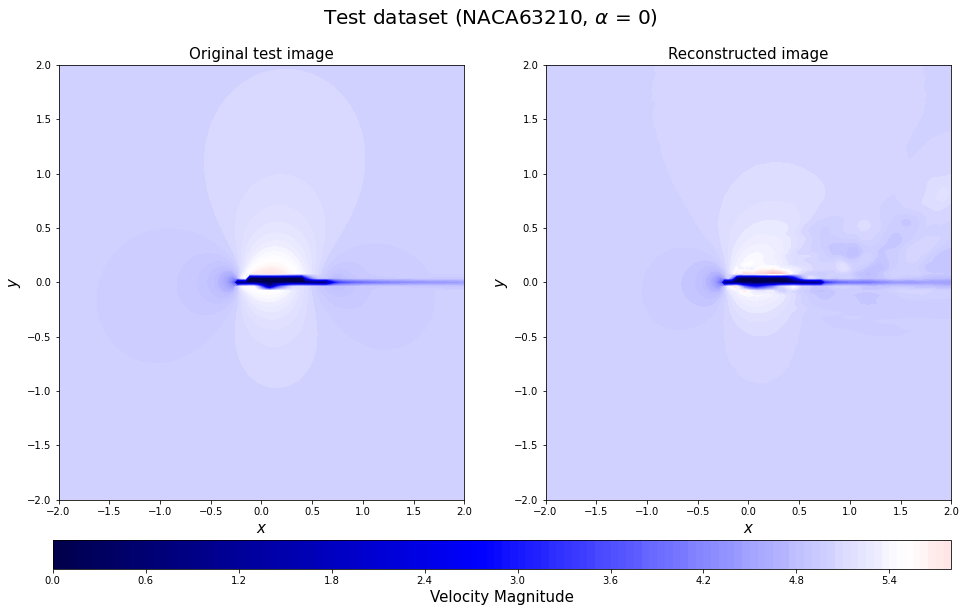

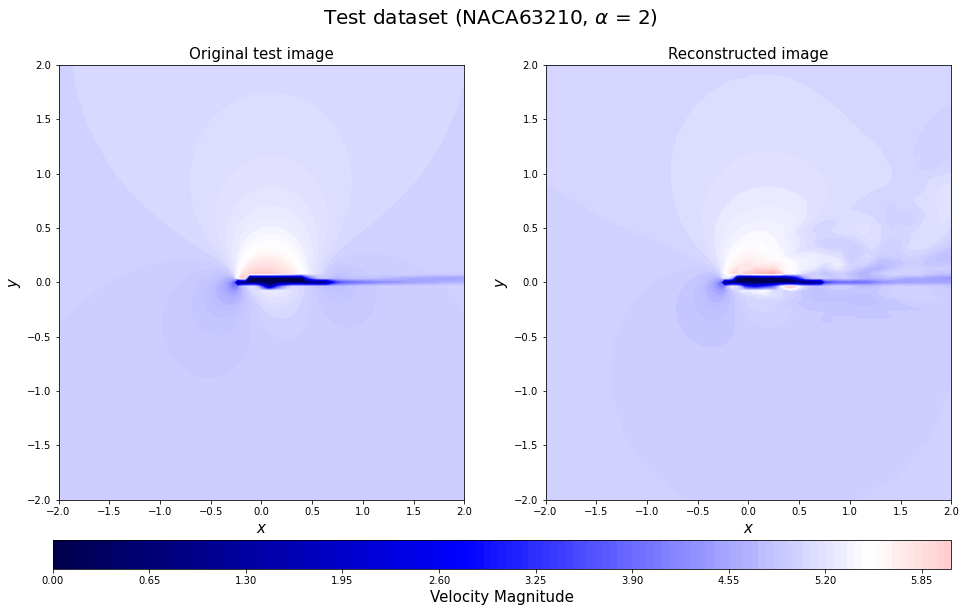

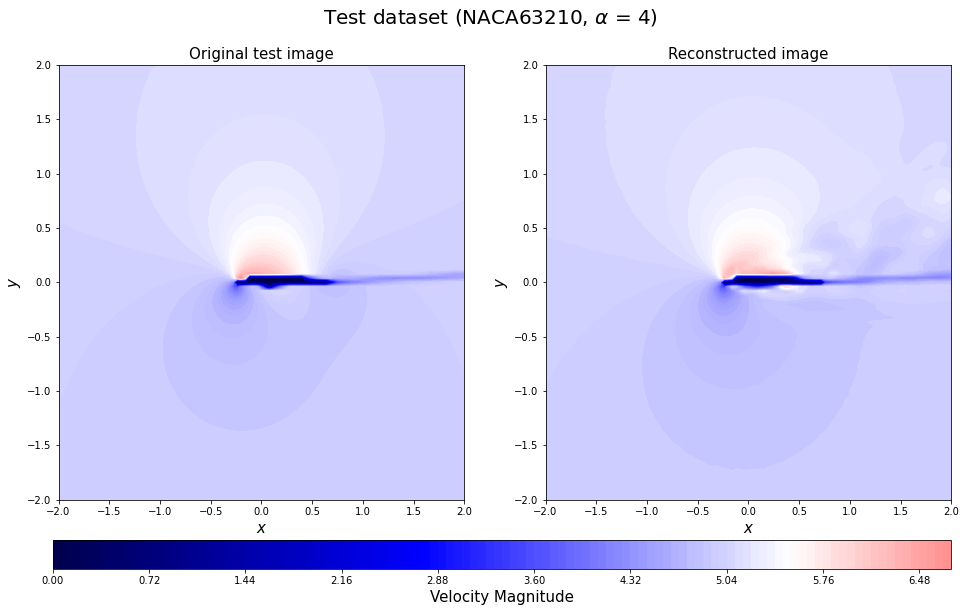

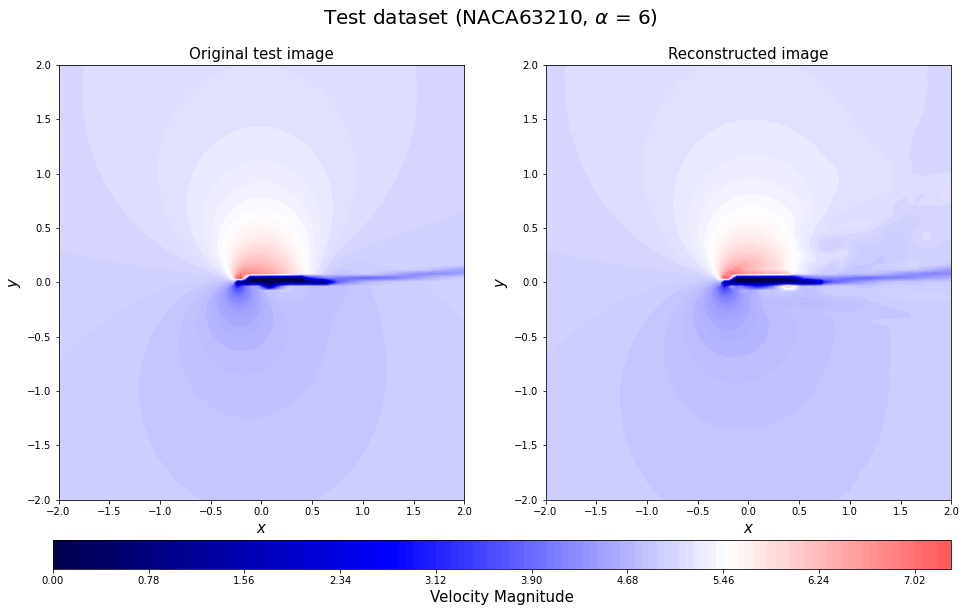

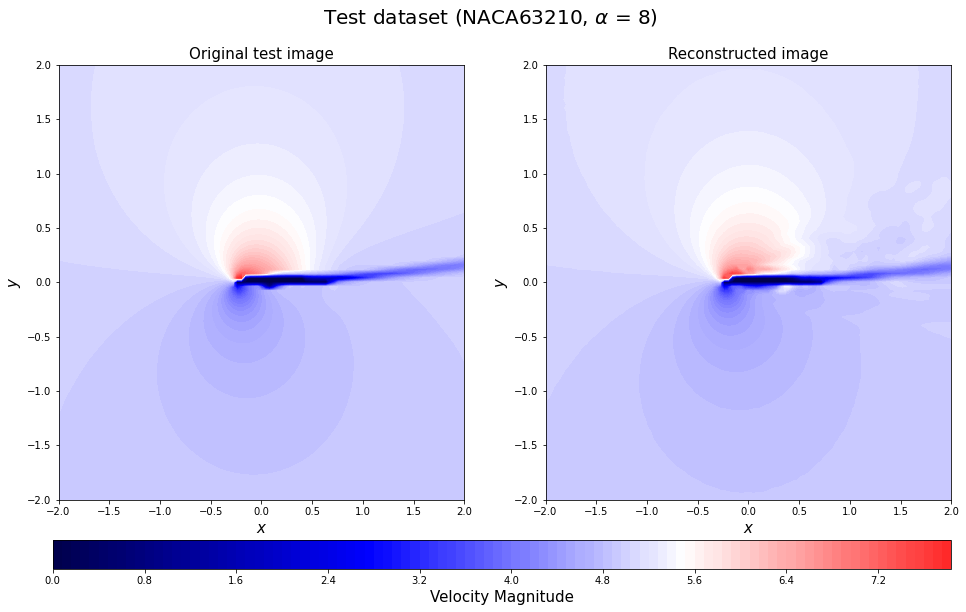

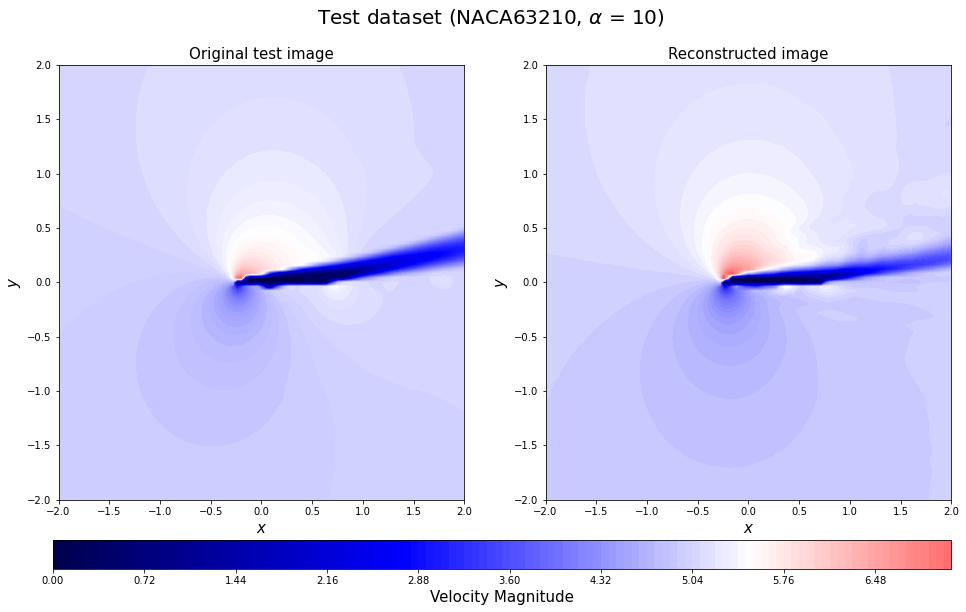

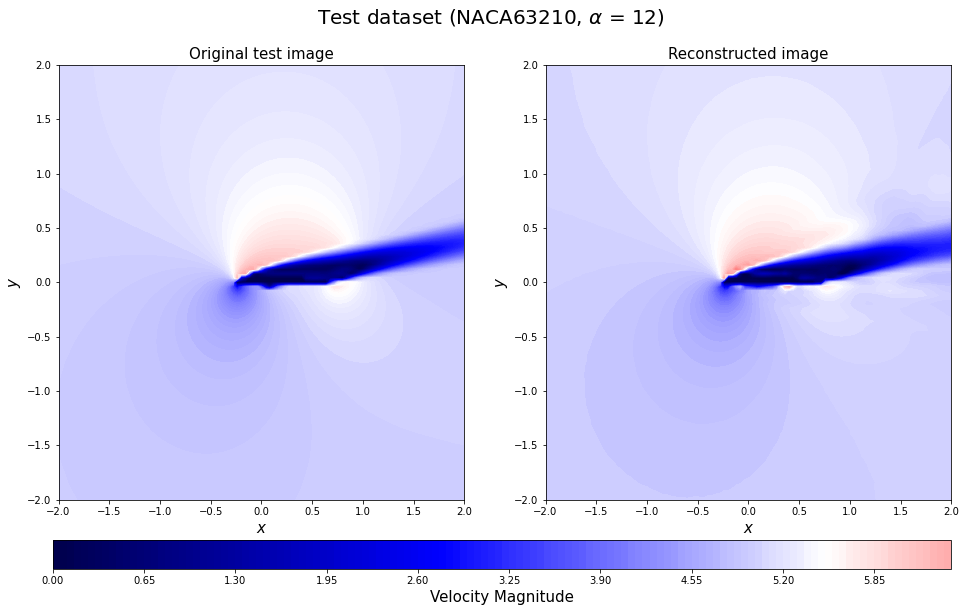

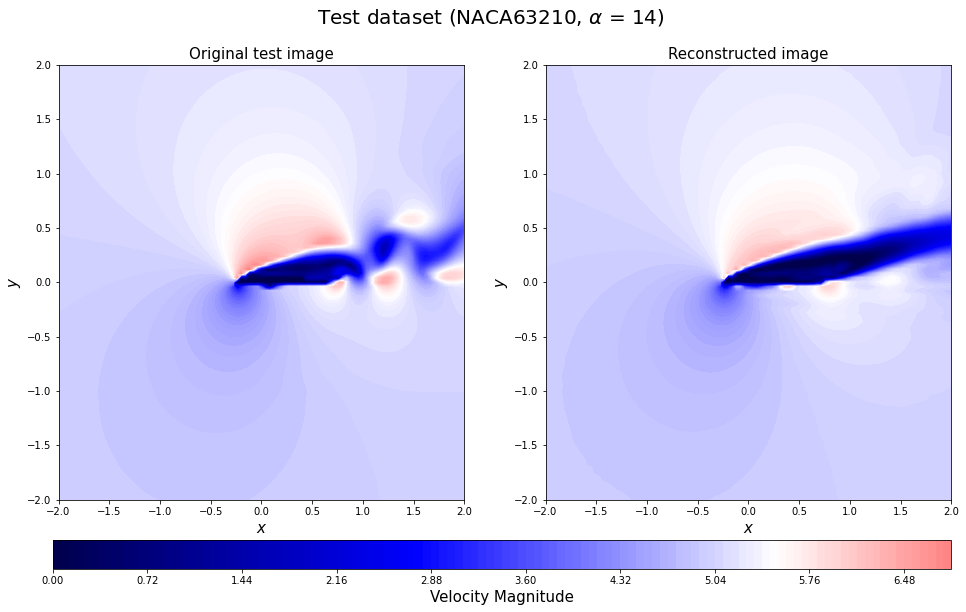

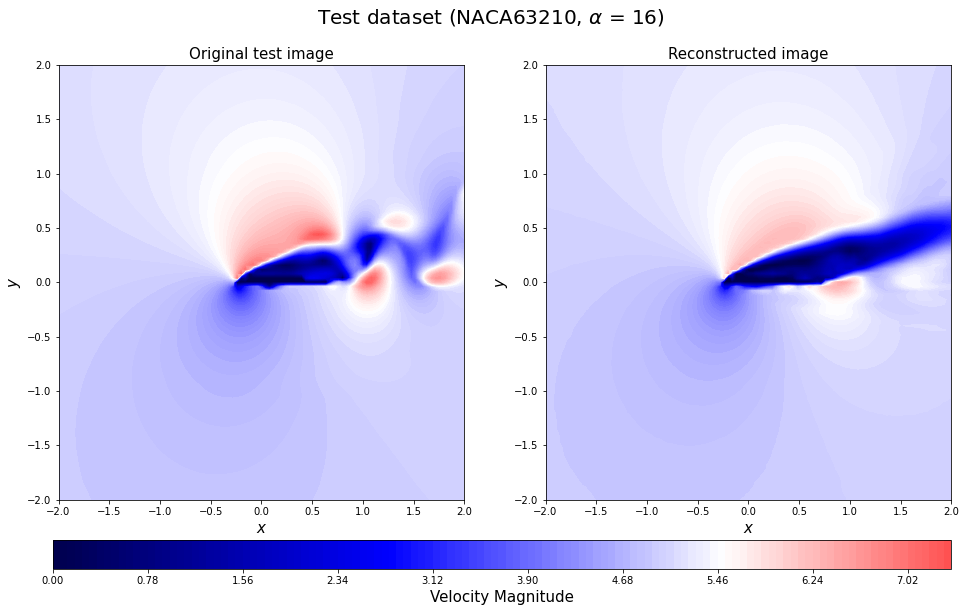

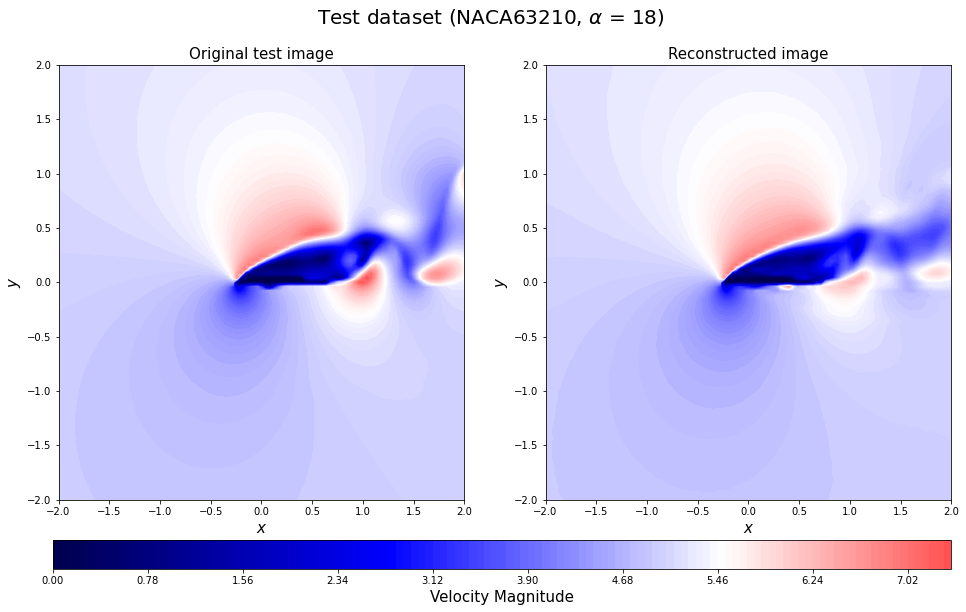

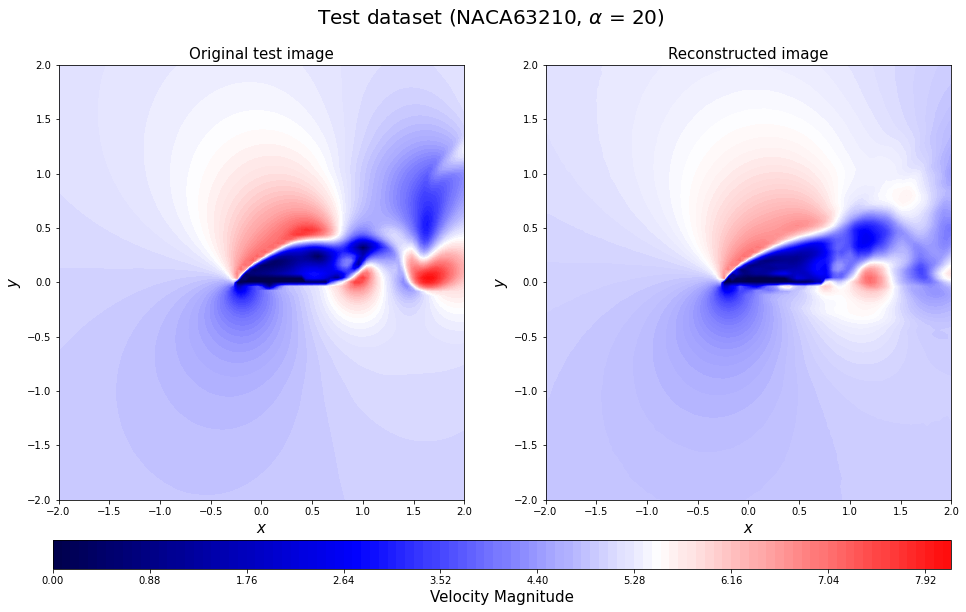

In [60]:
for c in range(0,16):
    plt.figure(figsize=(16, 8))
    y_test2_rotate = y_test[2*16+c].reshape(n_grid,n_grid)
    decoded_rotate = decoded_test[2*16+c].reshape(n_grid,n_grid)

    xrange = np.linspace(-2, 2, n_grid)
    yrange = np.linspace(-2, 2, n_grid)
    xmesh, ymesh = np.meshgrid(xrange, yrange)

    ax = plt.subplot(1, 2, 1)
    a1 = plt.contourf(xmesh, ymesh, y_test2_rotate, vmin=0, vmax=11, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Original test image', fontsize=15)

    # Display reconstruction
    ax = plt.subplot(1, 2, 2)
    a2 = plt.contourf(xmesh, ymesh, decoded_rotate, vmin=0, vmax=11, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Reconstructed image', fontsize=15)
    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(a1, cax=cax, orientation="horizontal")
    cbar.set_label('Velocity Magnitude', fontsize=15)
    #cbar.set_ticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

    plt.suptitle(r'Test dataset (%s, $\alpha$ = %d)' %(np.array2string(geo_test[2*16+c])[3:-2], aa_test[2*16+c]),fontsize=20)
    save_fig_name = 
    plt.savefig("20221012AeroCNNIIwithUnet(2CNNlayer)")
    plt.show()

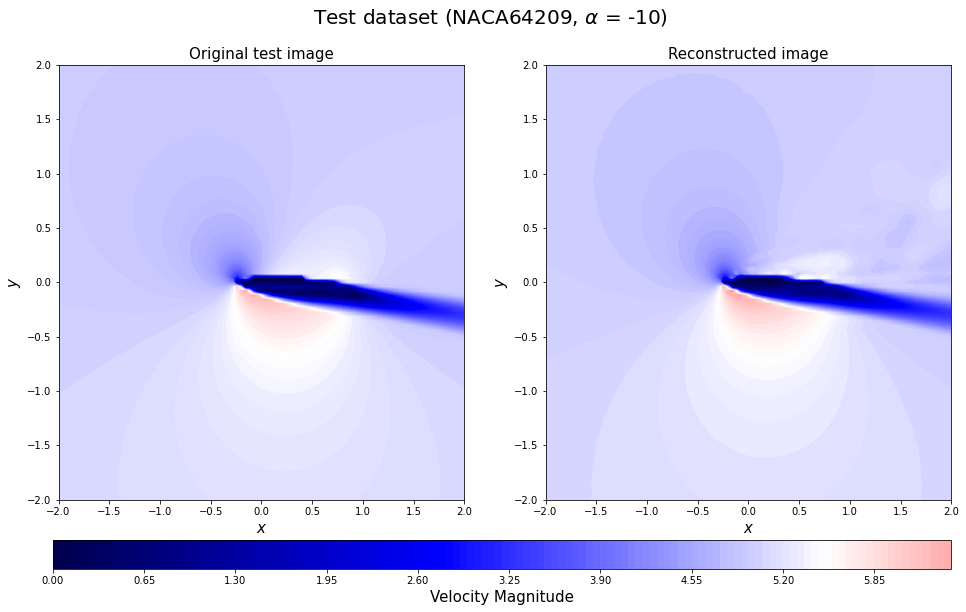

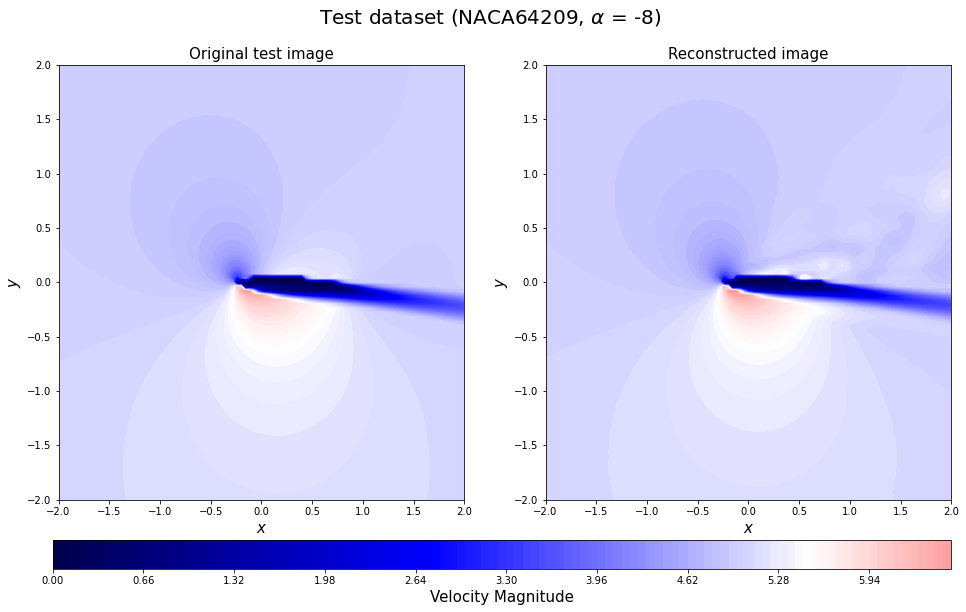

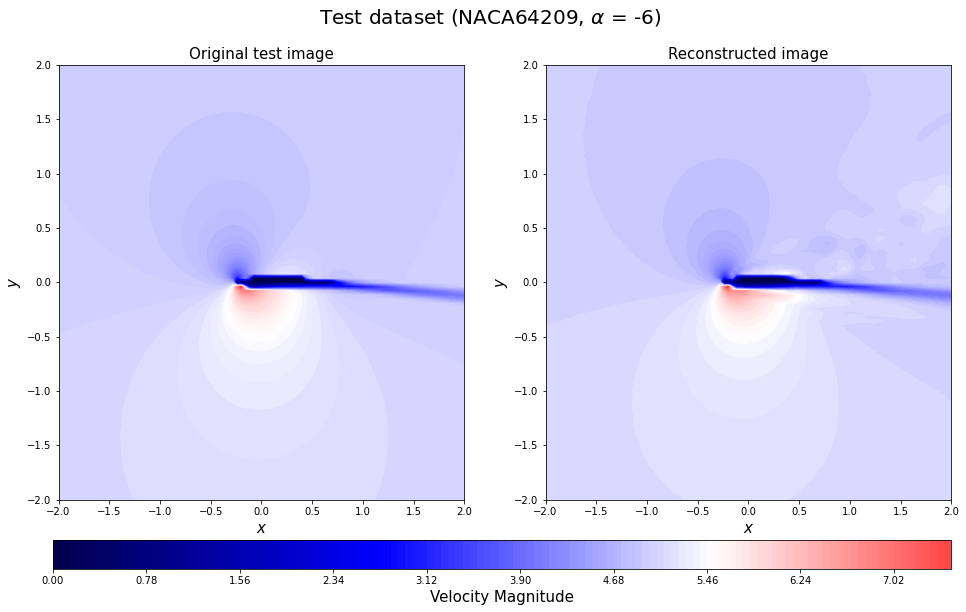

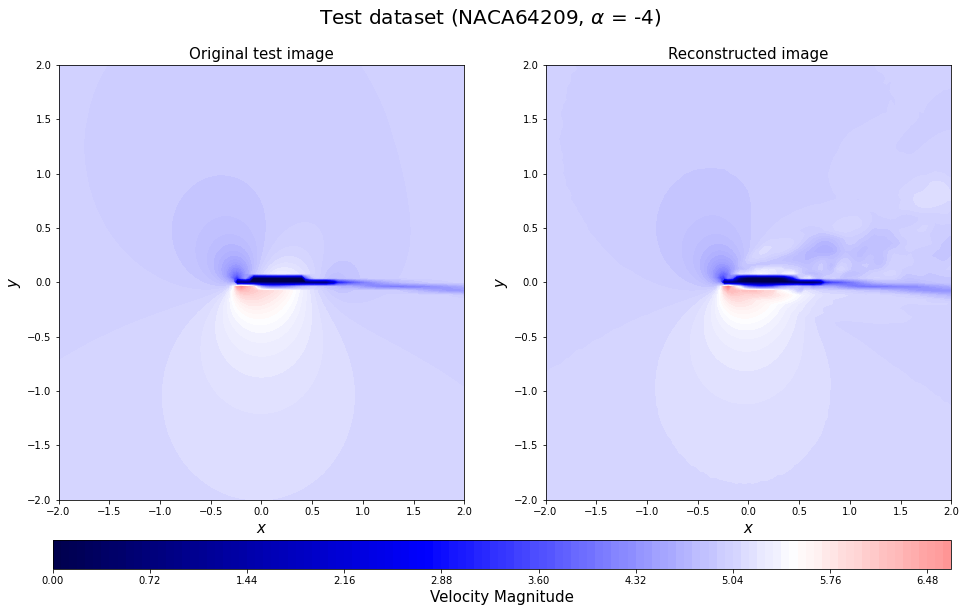

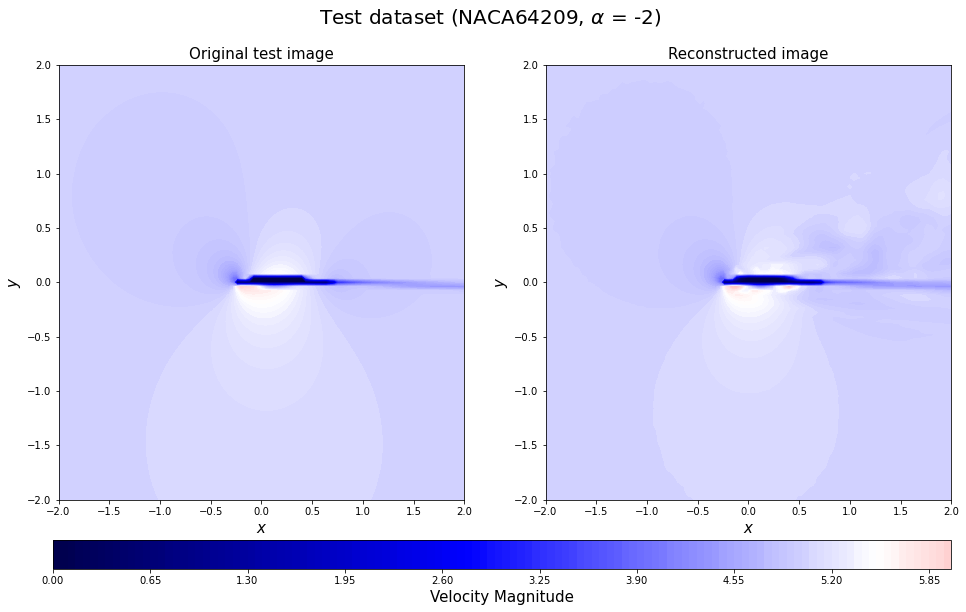

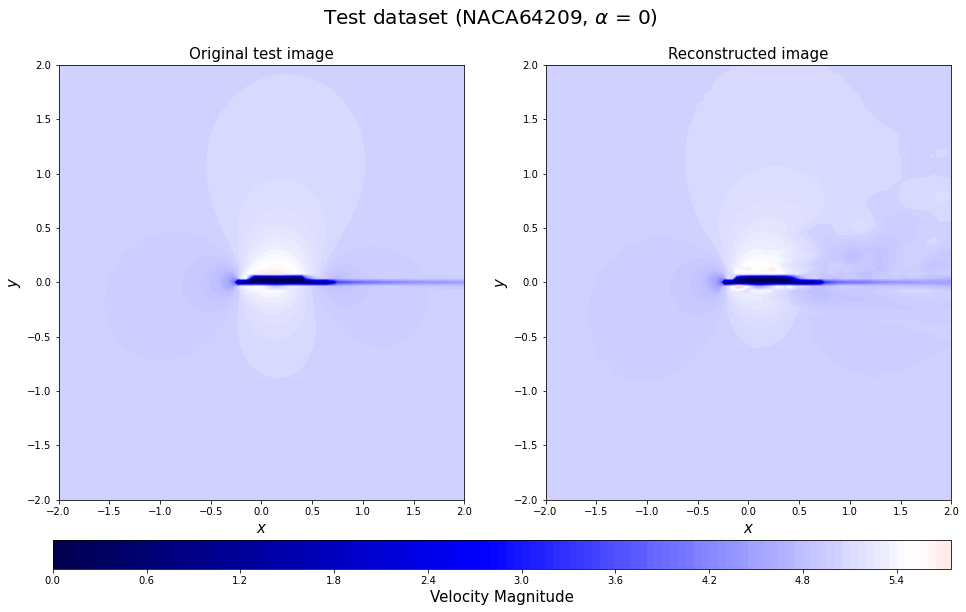

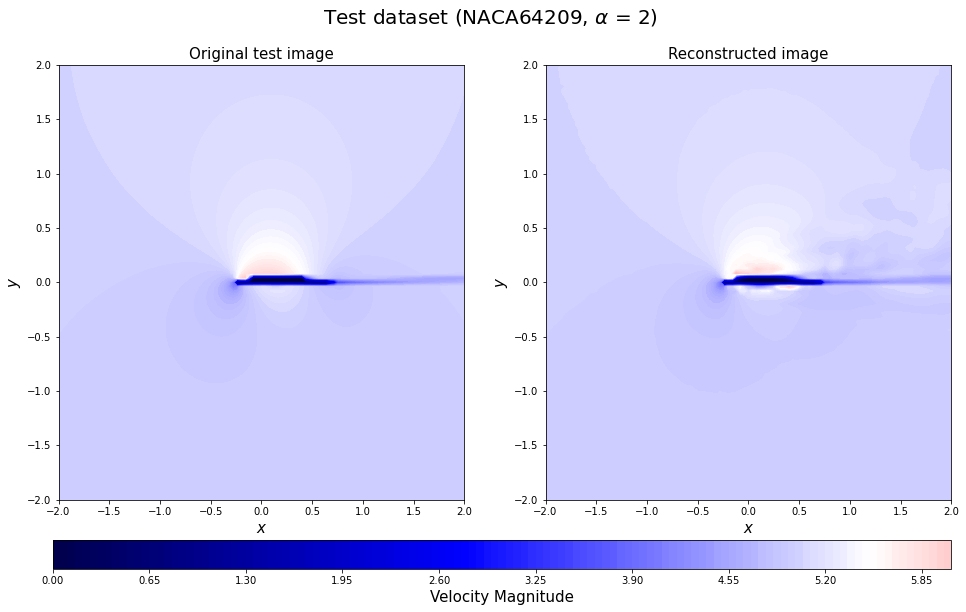

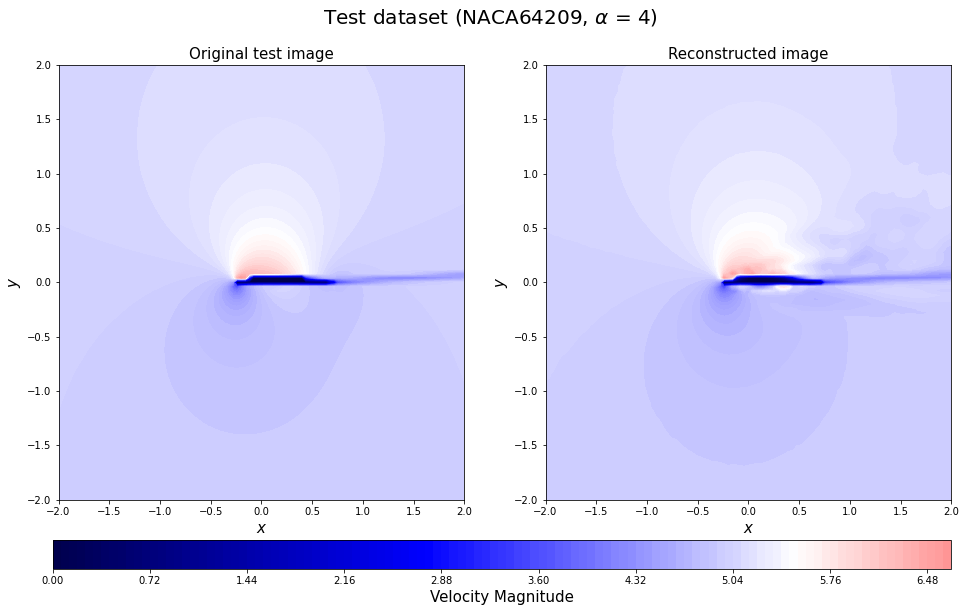

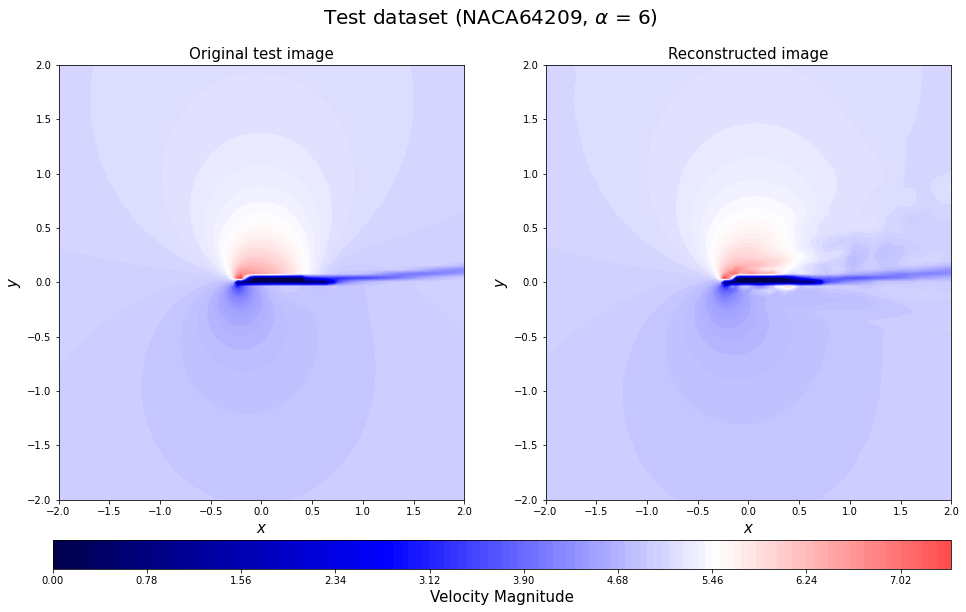

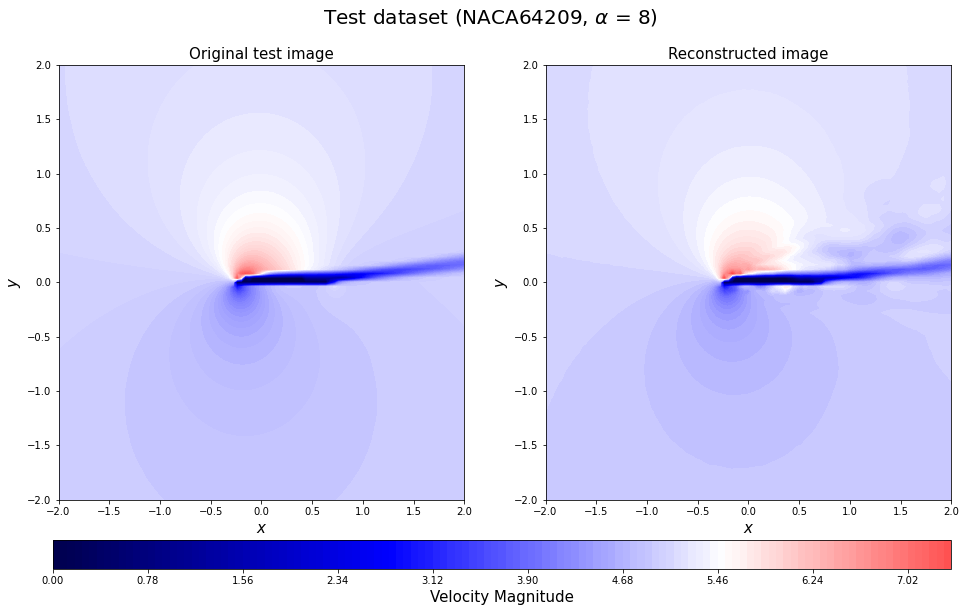

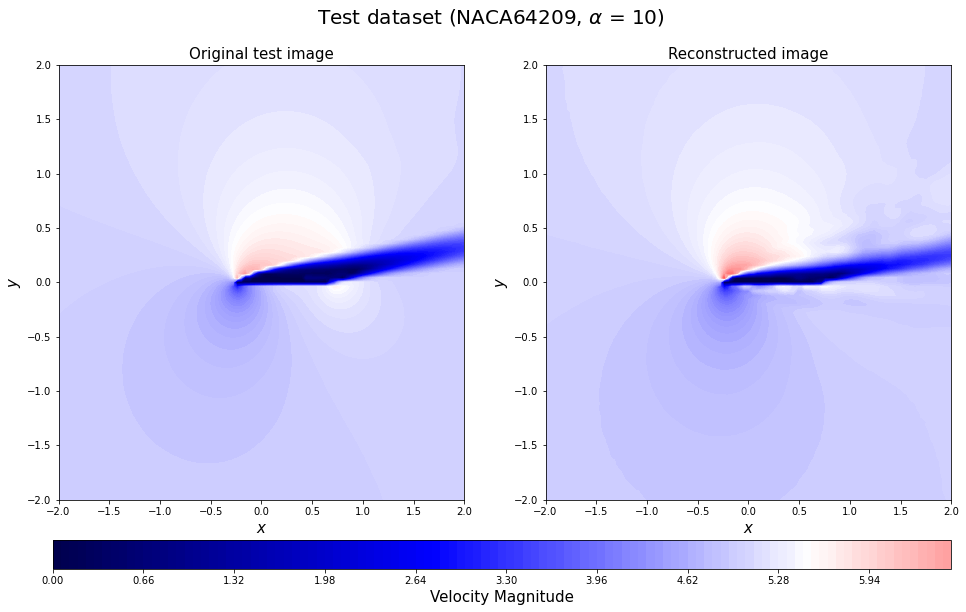

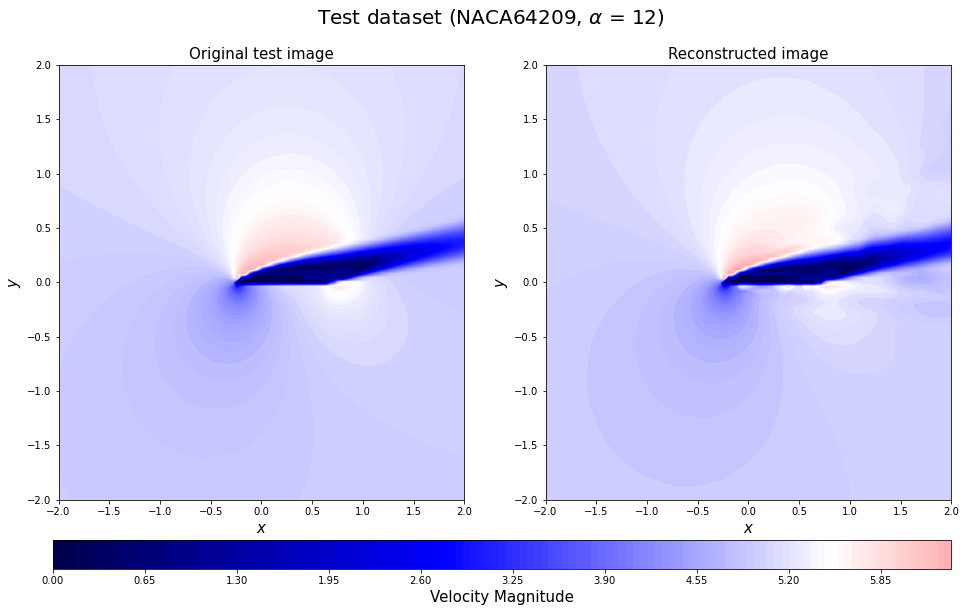

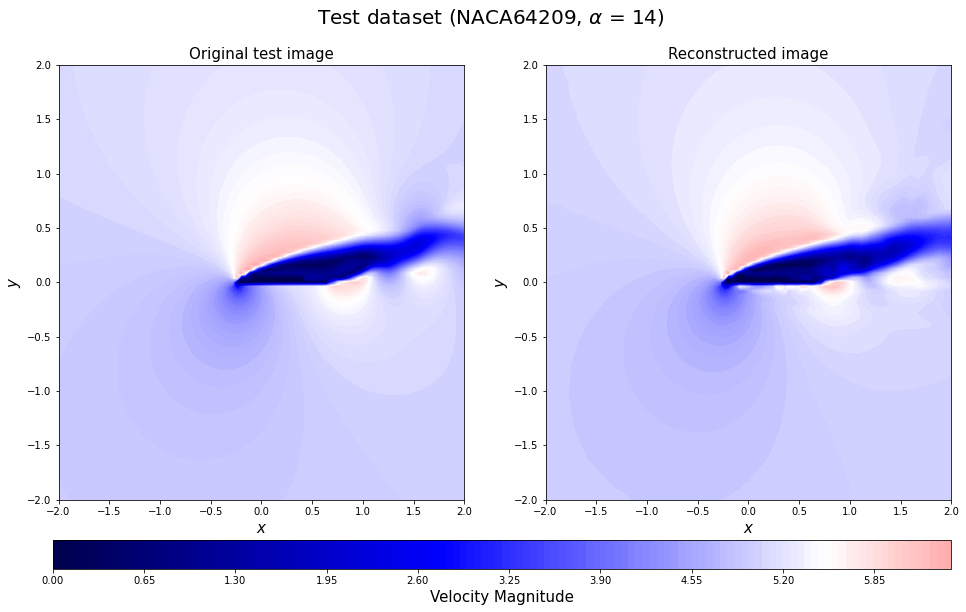

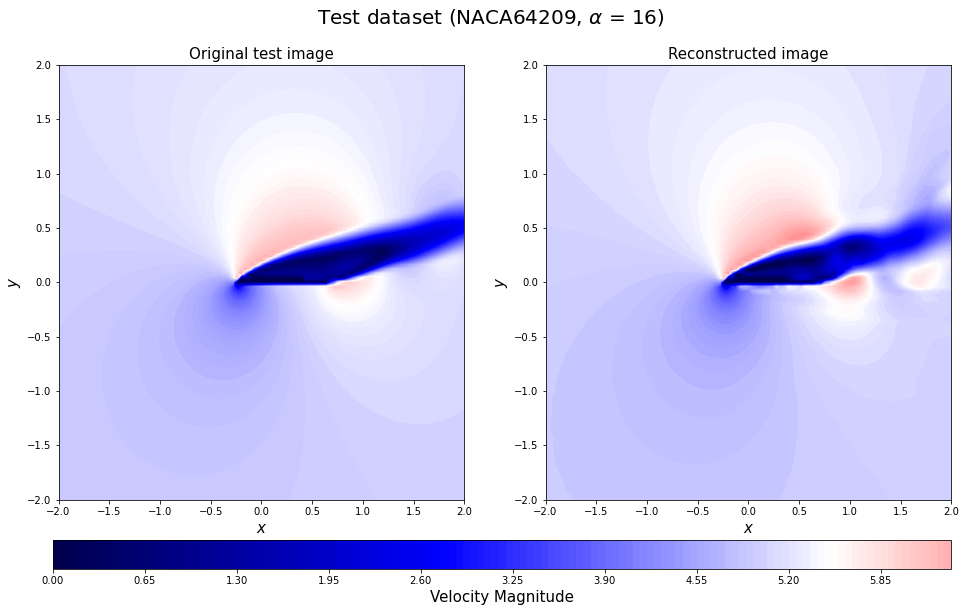

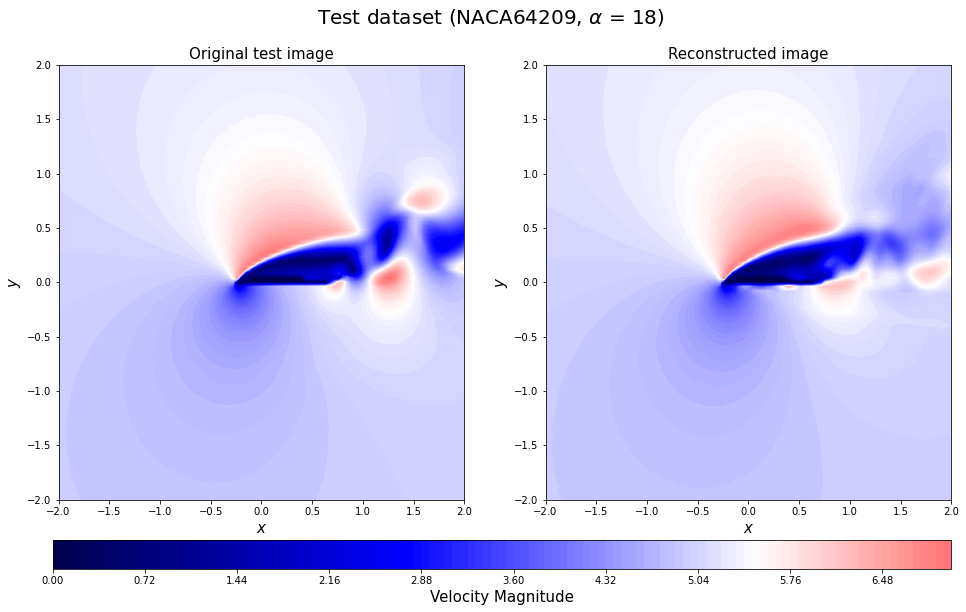

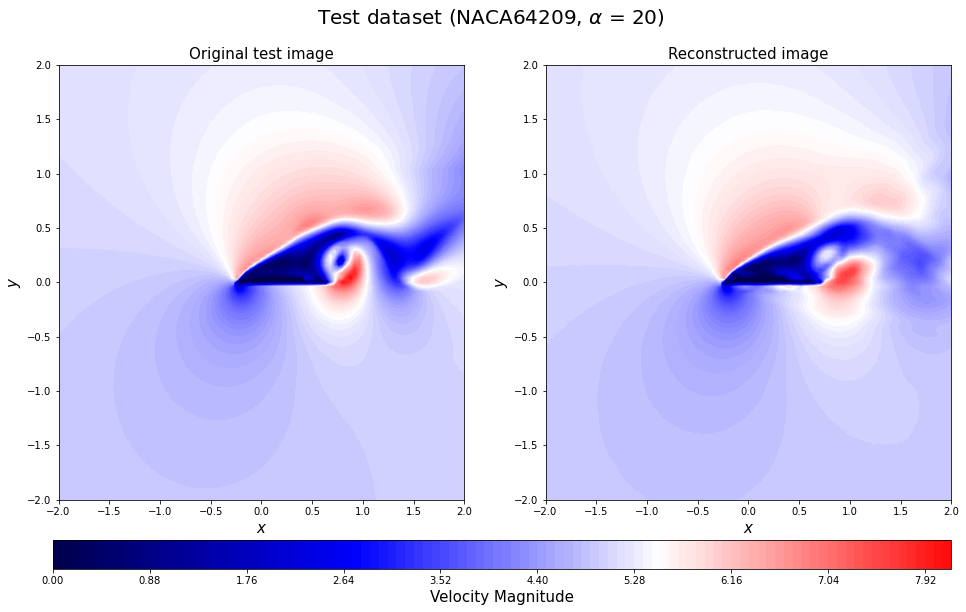

In [61]:
for c in range(0,16):
    plt.figure(figsize=(16, 8))
    y_test0_rotate = y_test[c].reshape(n_grid,n_grid)
    decoded_rotate = decoded_test[c].reshape(n_grid,n_grid)

    xrange = np.linspace(-2, 2, n_grid)
    yrange = np.linspace(-2, 2, n_grid)
    xmesh, ymesh = np.meshgrid(xrange, yrange)

    ax = plt.subplot(1, 2, 1)
    a1 = plt.contourf(xmesh, ymesh, y_test0_rotate, vmin=0, vmax=11, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Original test image', fontsize=15)

    # Display reconstruction
    ax = plt.subplot(1, 2, 2)
    a2 = plt.contourf(xmesh, ymesh, decoded_rotate, vmin=0, vmax=11, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Reconstructed image', fontsize=15)
    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(a1, cax=cax, orientation="horizontal")
    cbar.set_label('Velocity Magnitude', fontsize=15)
    #cbar.set_ticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

    plt.suptitle(r'Test dataset (%s, $\alpha$ = %d)' %(np.array2string(geo_test[c])[3:-2], aa_test[c]),fontsize=20)
    plt.show()

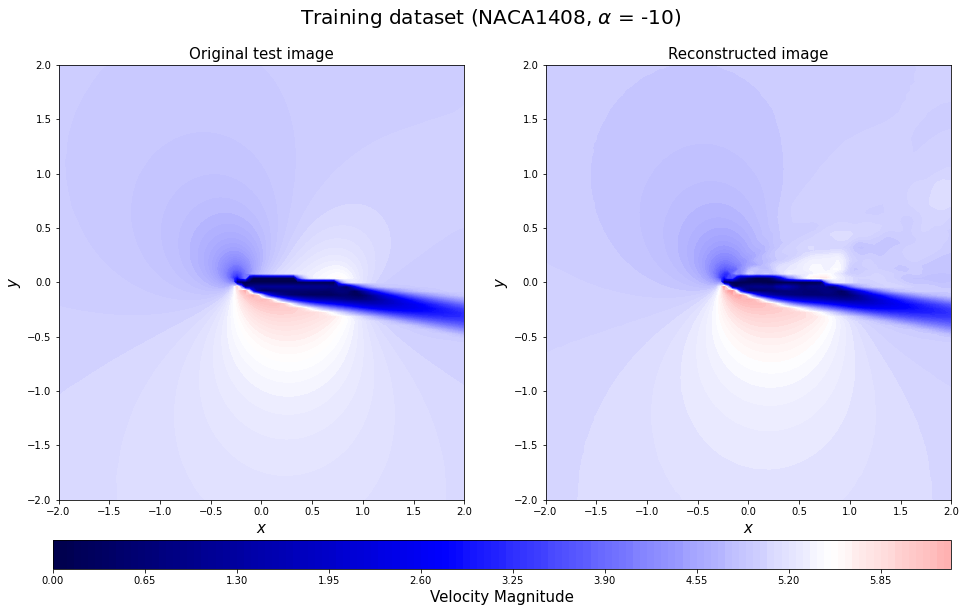

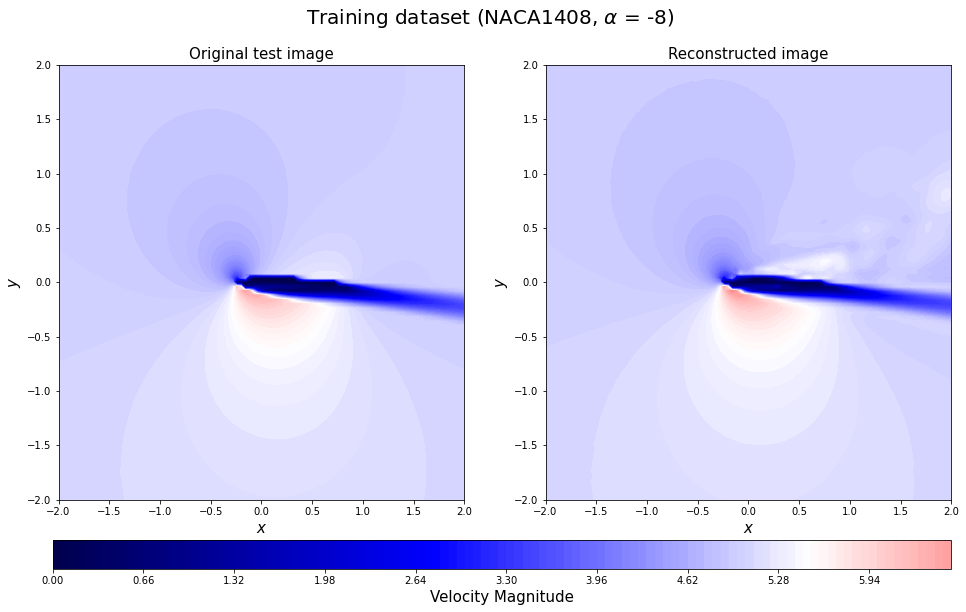

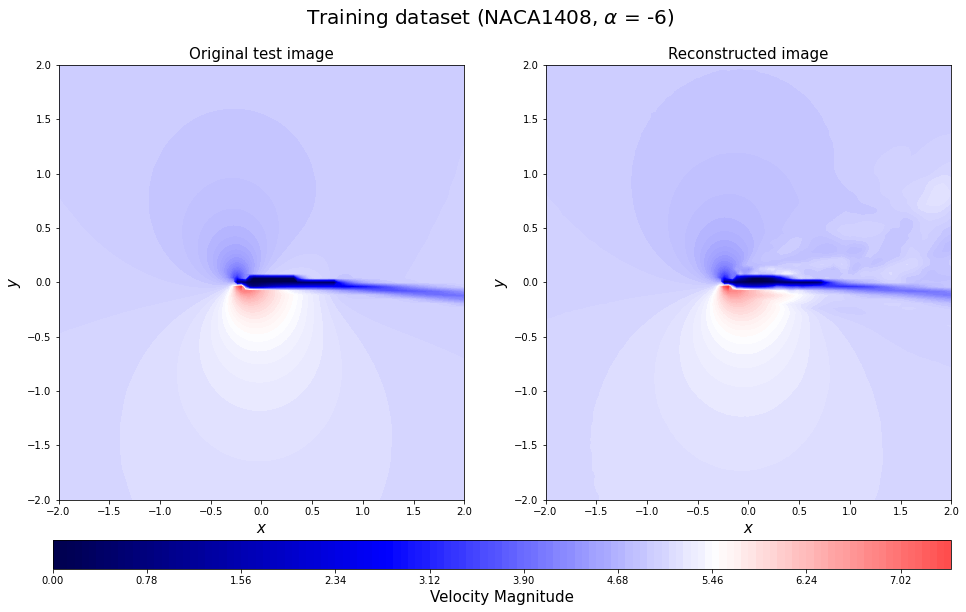

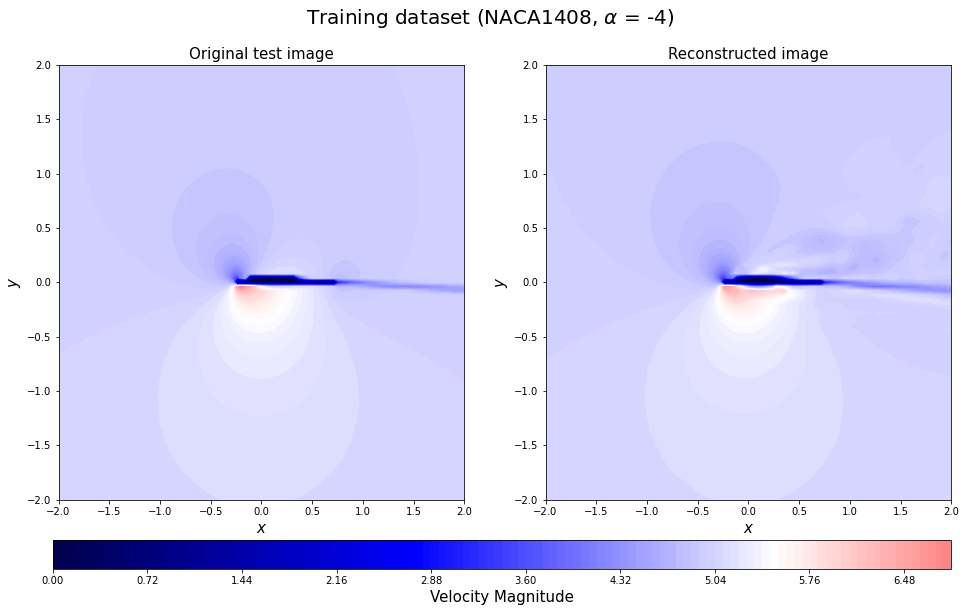

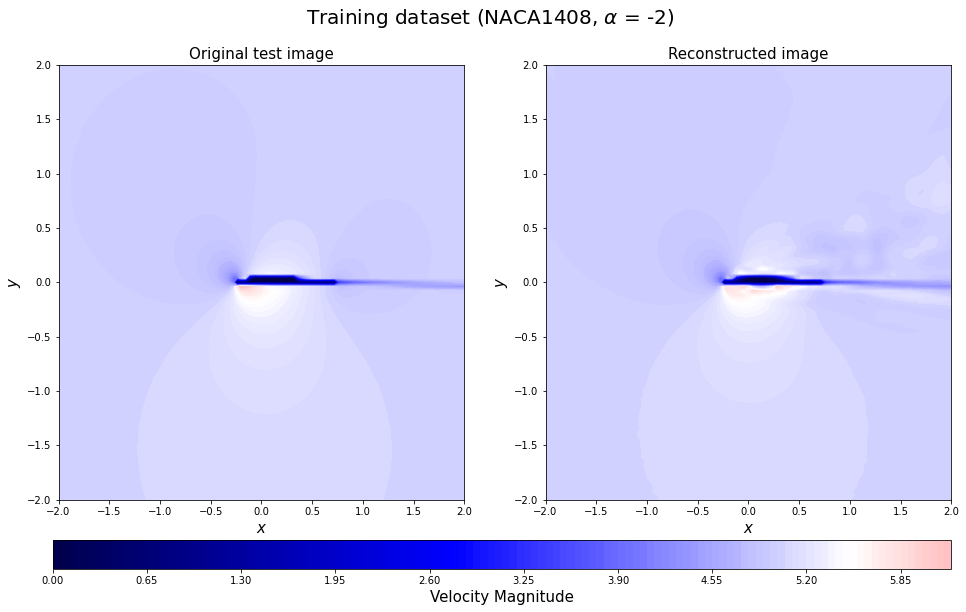

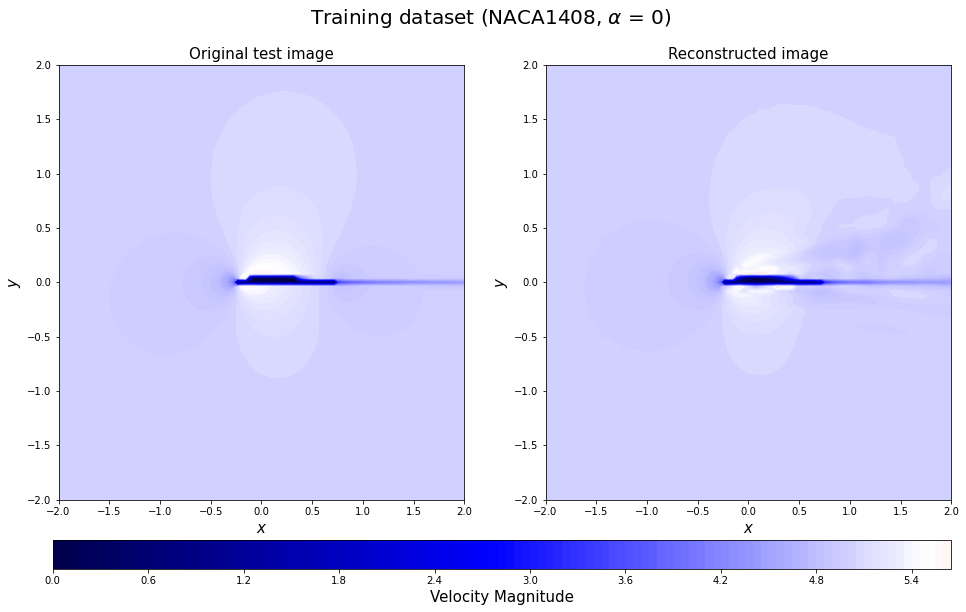

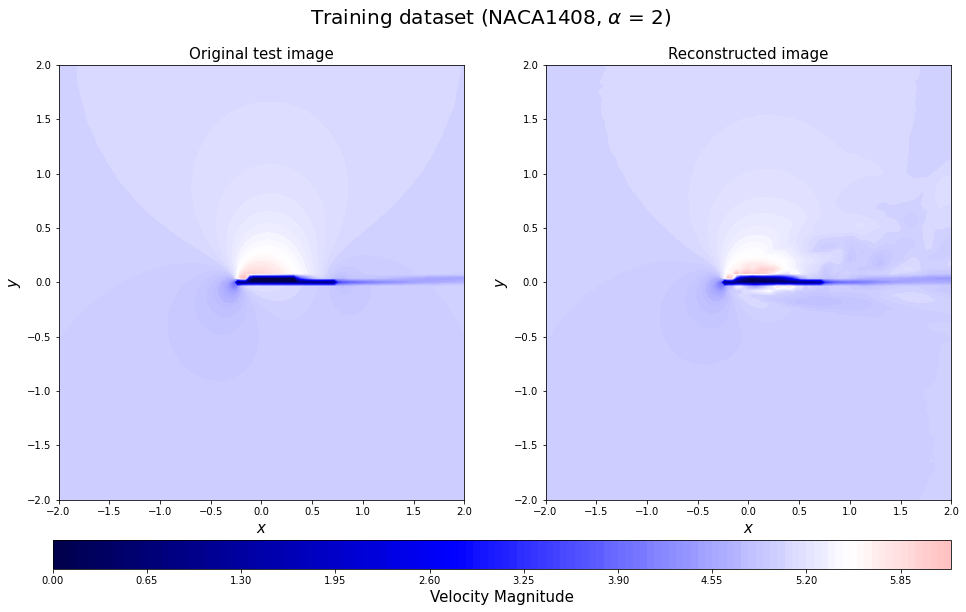

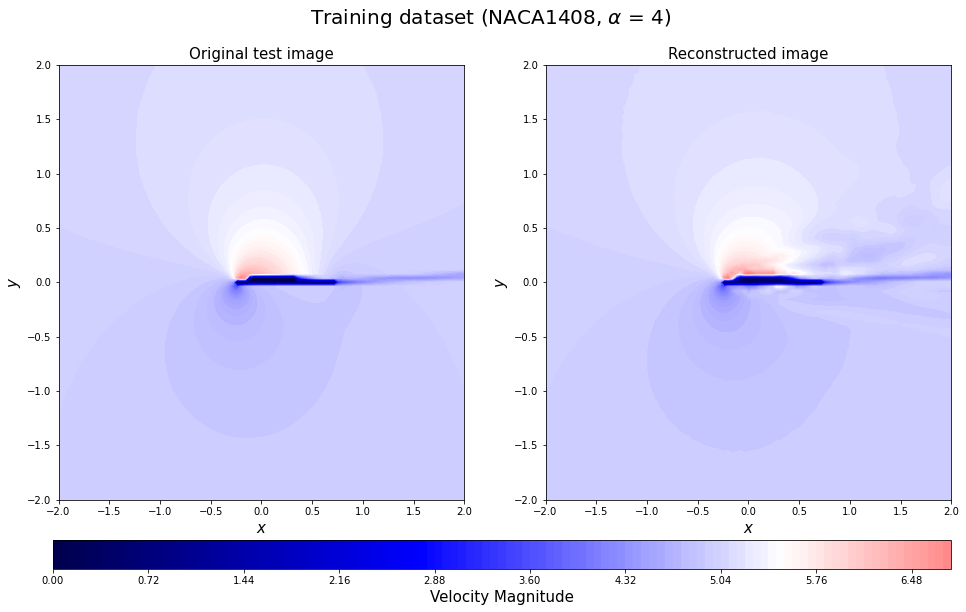

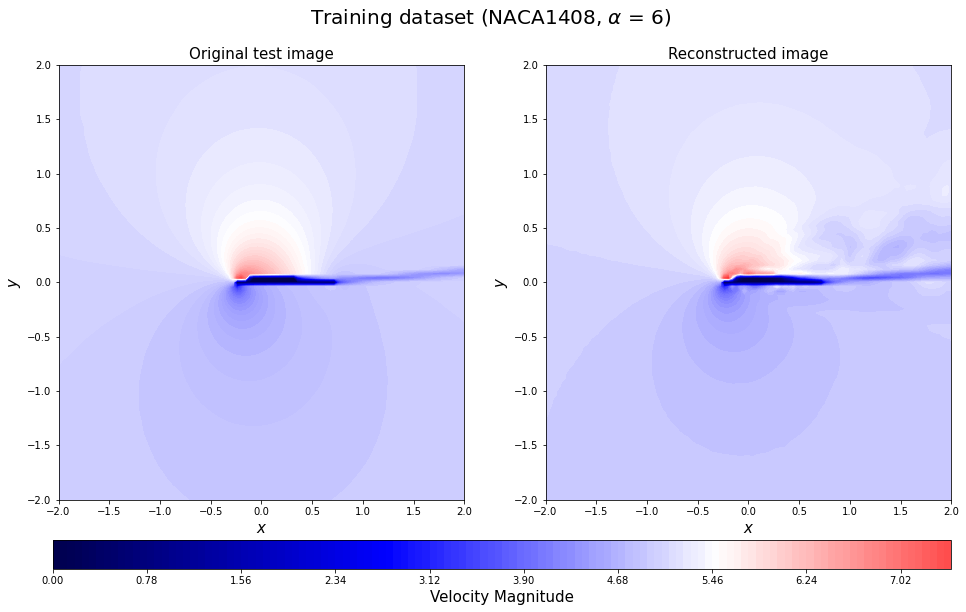

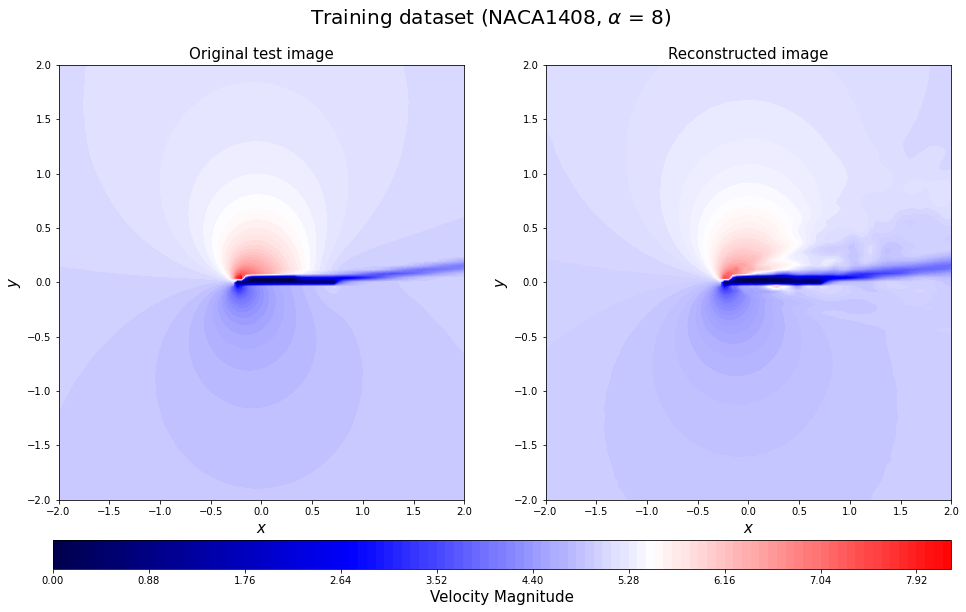

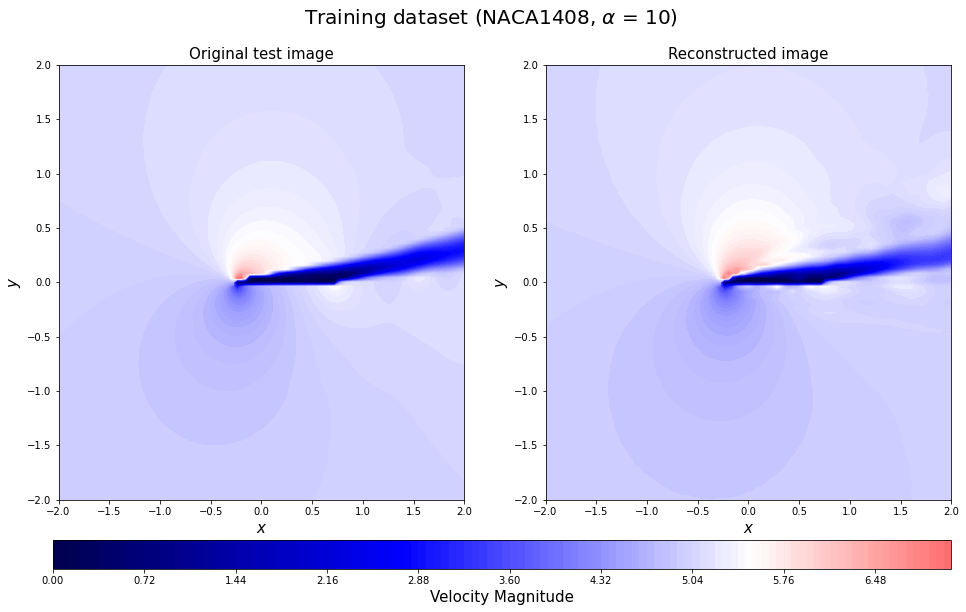

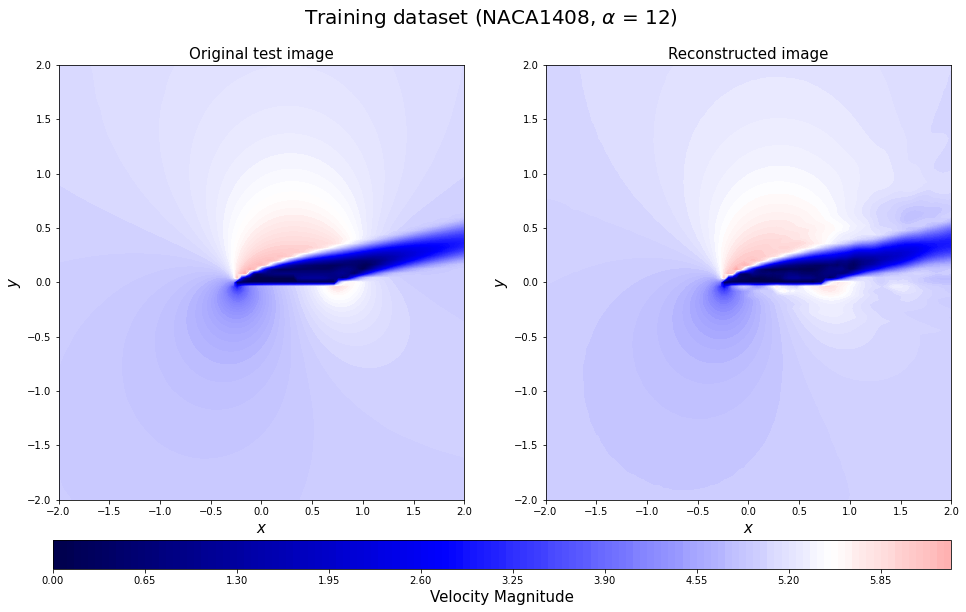

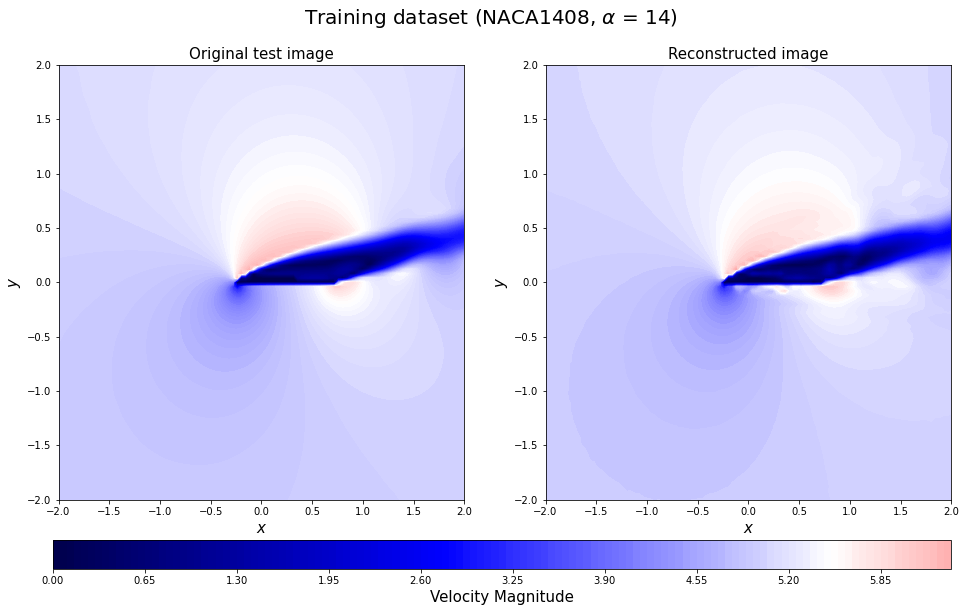

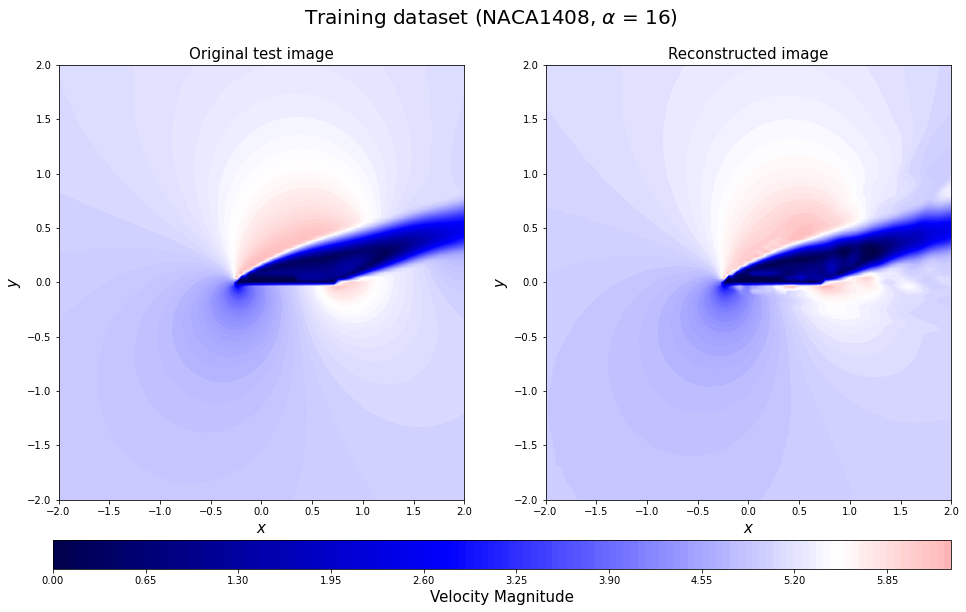

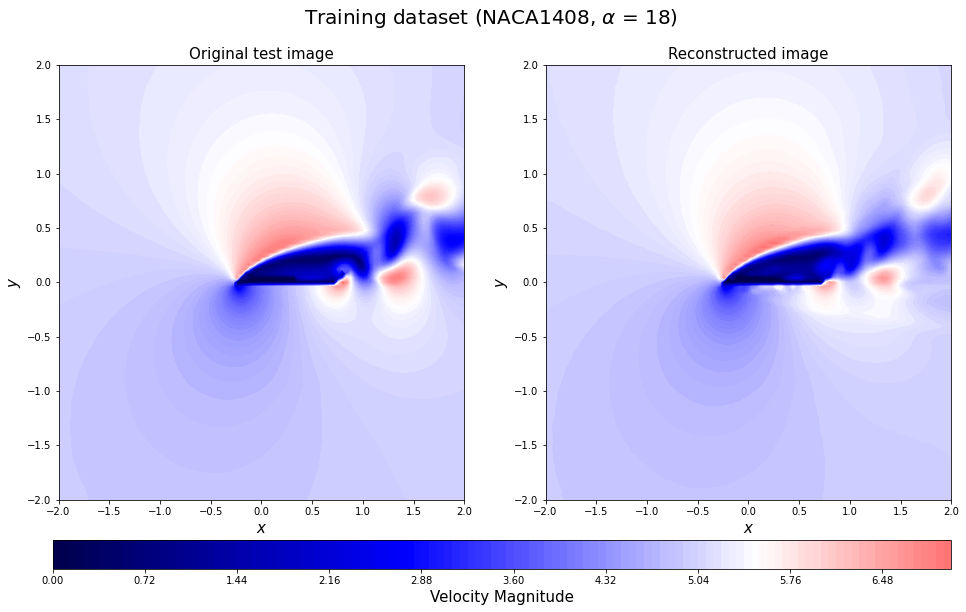

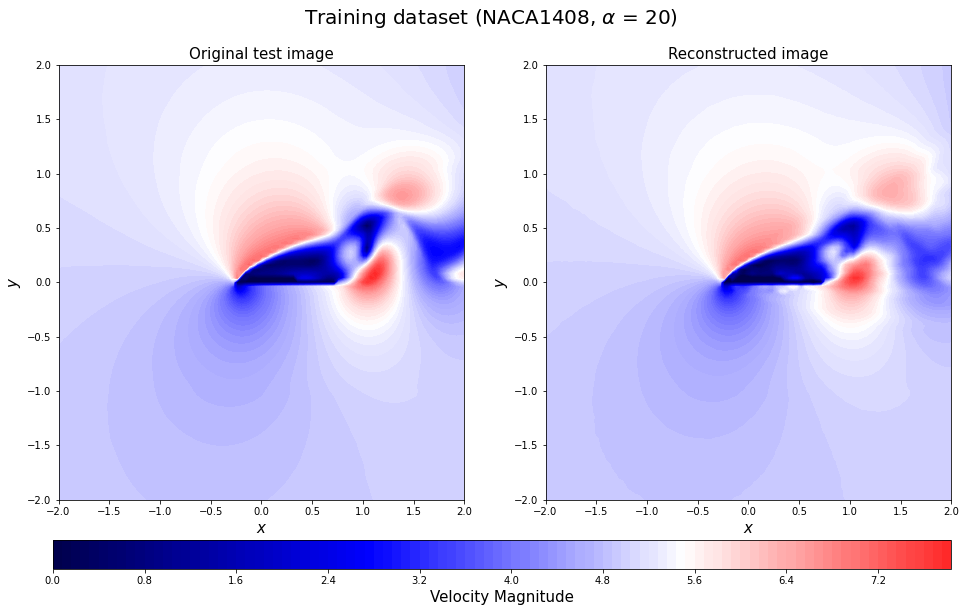

In [62]:
for c in range(0,16):
    plt.figure(figsize=(16, 8))
    y_train0_rotate = y_train[c].reshape(n_grid,n_grid)
    decoded_rotate = decoded_train[c].reshape(n_grid,n_grid)

    xrange = np.linspace(-2, 2, n_grid)
    yrange = np.linspace(-2, 2, n_grid)
    xmesh, ymesh = np.meshgrid(xrange, yrange)

    ax = plt.subplot(1, 2, 1)
    a1 = plt.contourf(xmesh, ymesh, y_train0_rotate, vmin=0, vmax=11, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Original test image', fontsize=15)

    # Display reconstruction
    ax = plt.subplot(1, 2, 2)
    a2 = plt.contourf(xmesh, ymesh, decoded_rotate, vmin=0, vmax=11, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Reconstructed image', fontsize=15)
    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(a1, cax=cax, orientation="horizontal")
    cbar.set_label('Velocity Magnitude', fontsize=15)
    #cbar.set_ticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

    plt.suptitle(r'Training dataset (%s, $\alpha$ = %d)' %(np.array2string(geo_train[c])[3:-2], aa_train[c]),fontsize=20)
    plt.show()

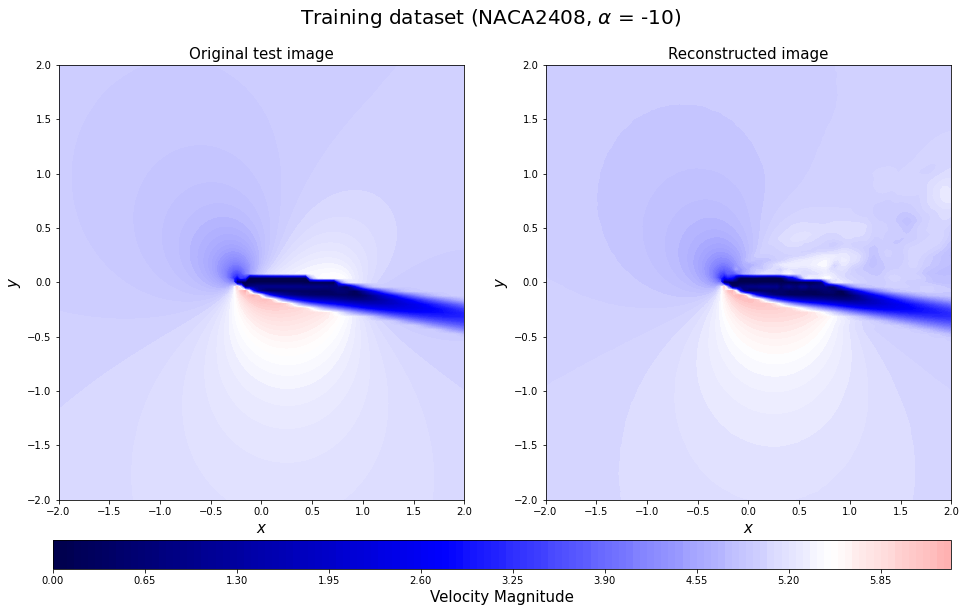

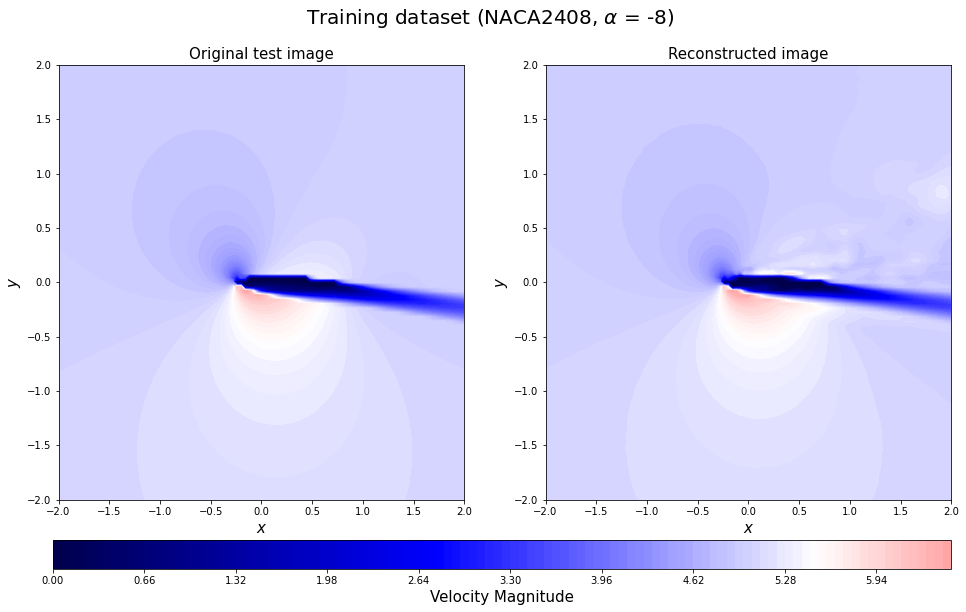

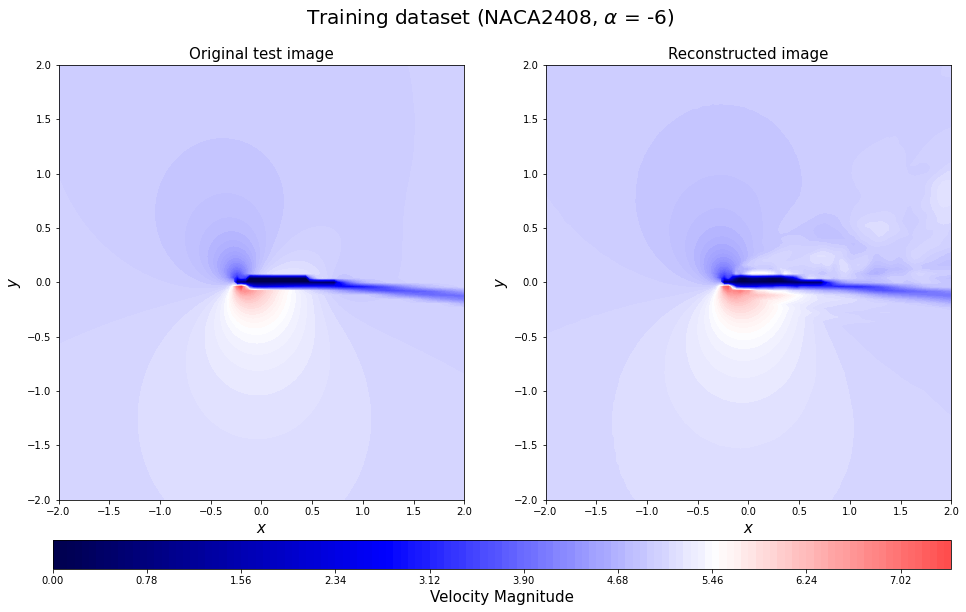

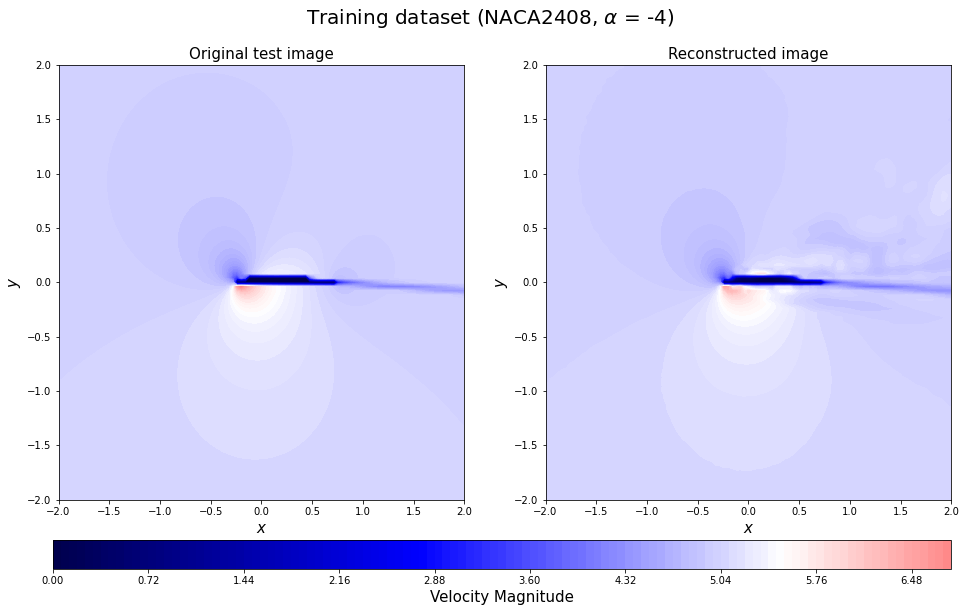

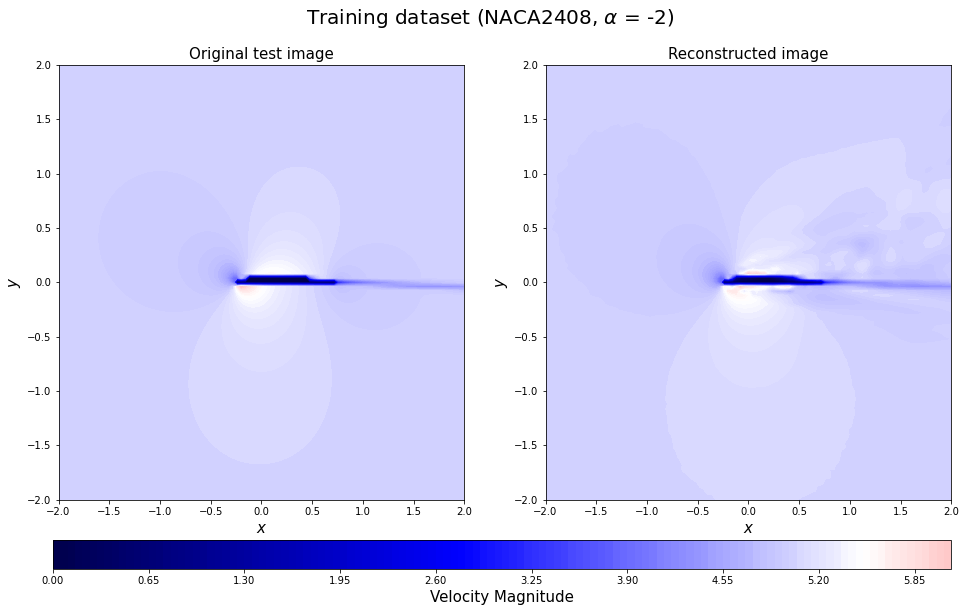

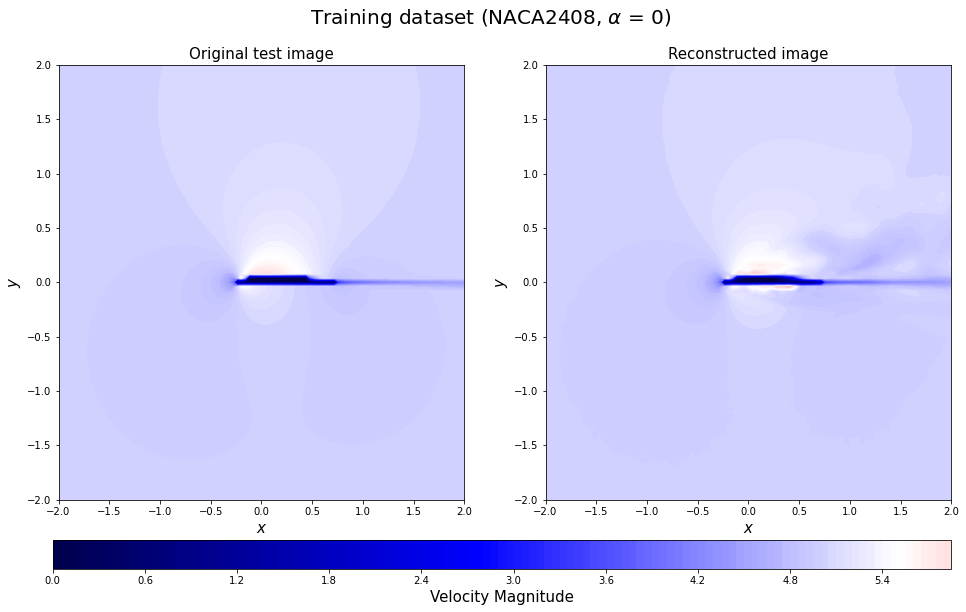

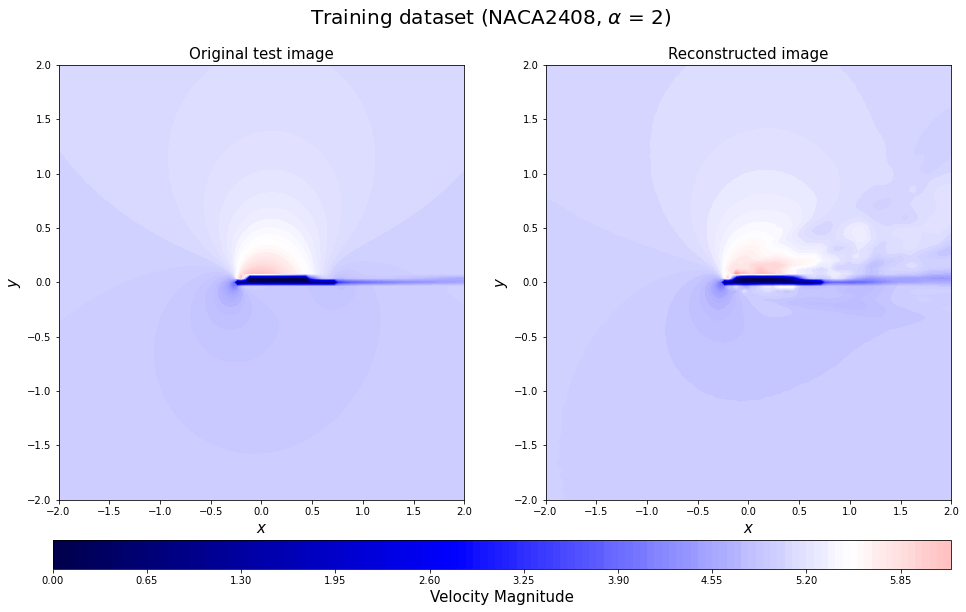

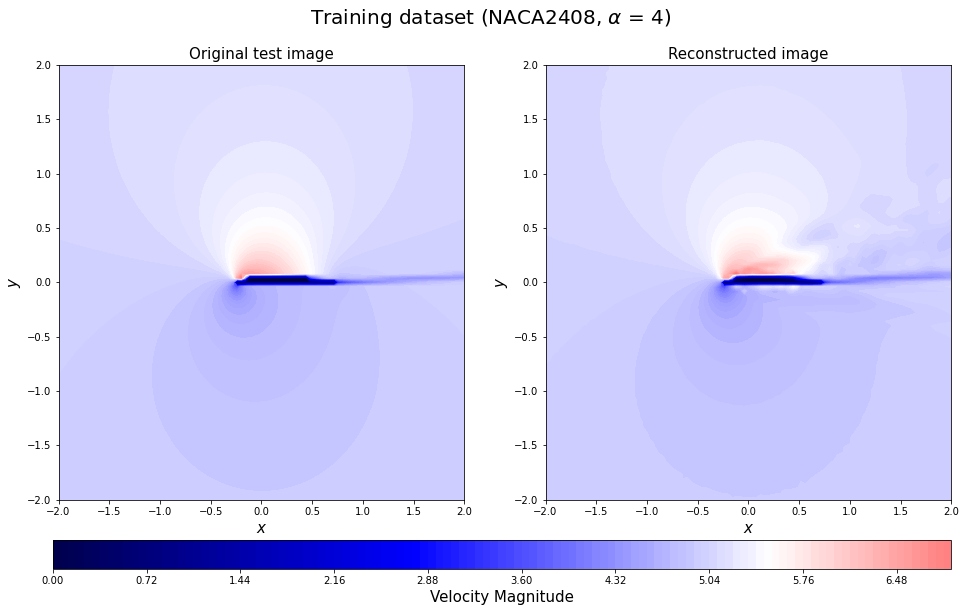

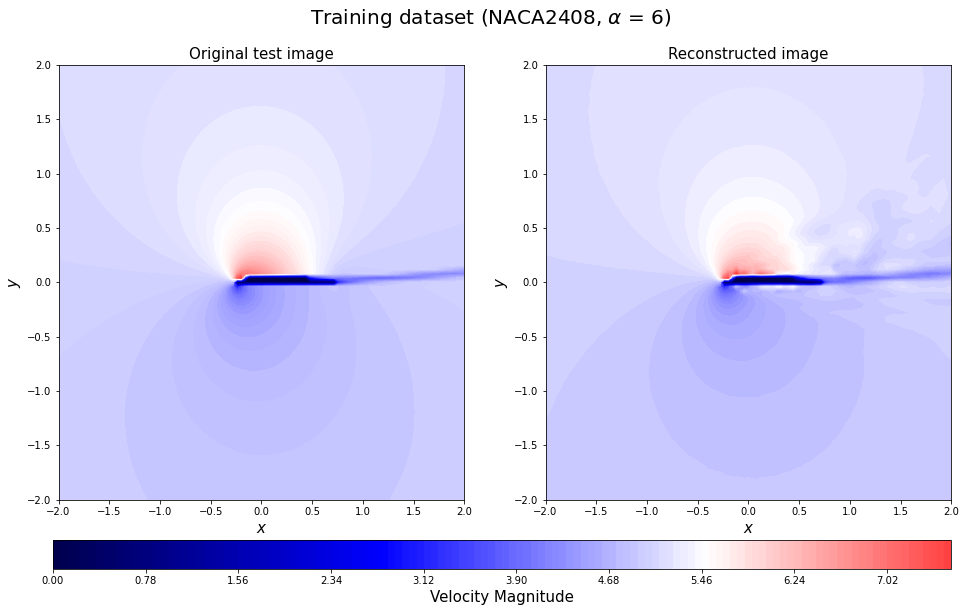

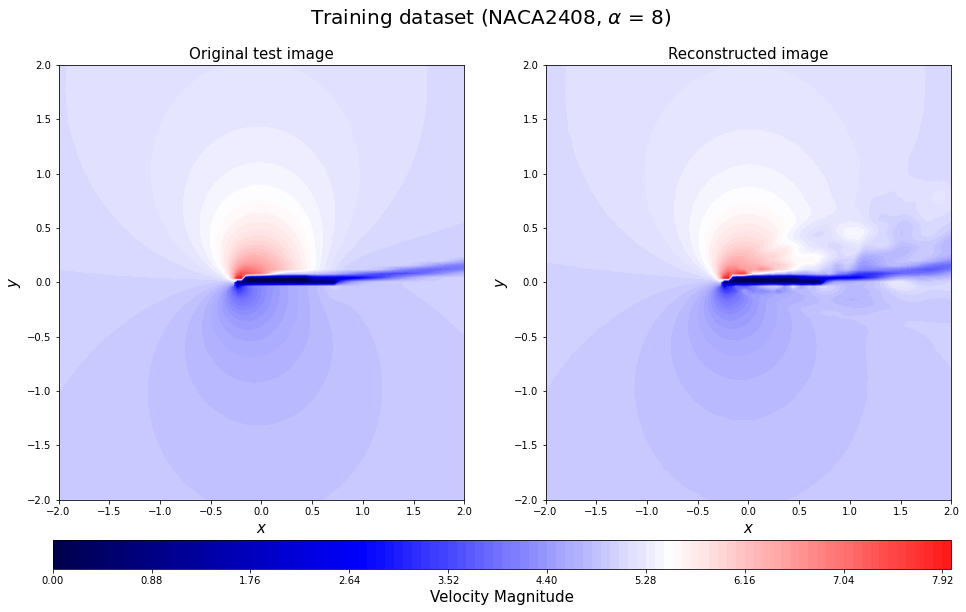

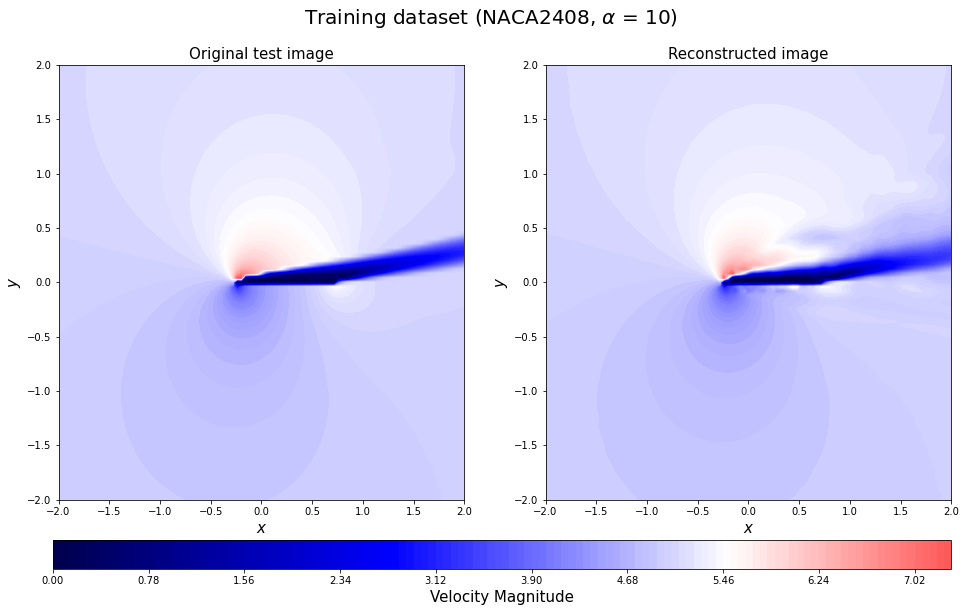

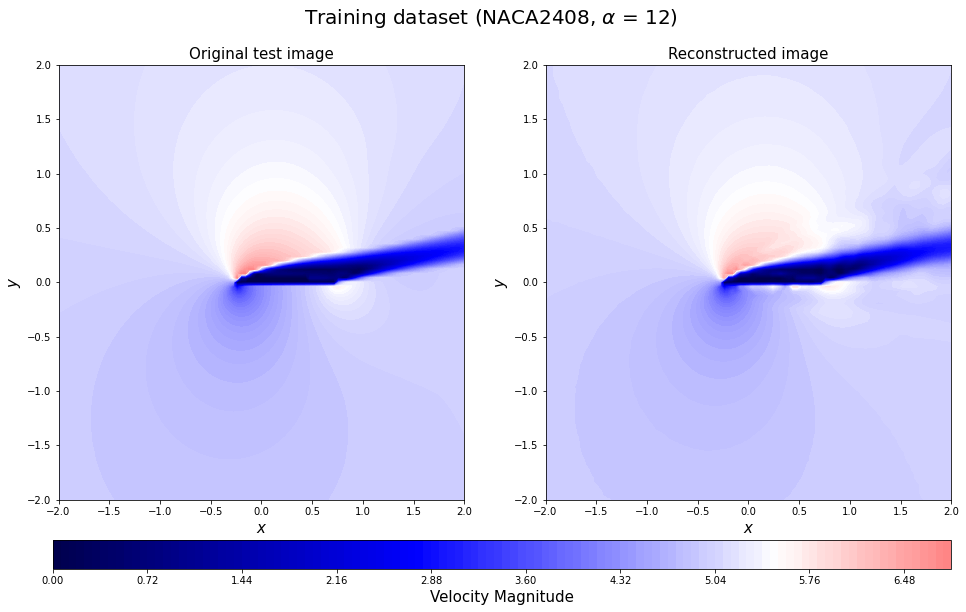

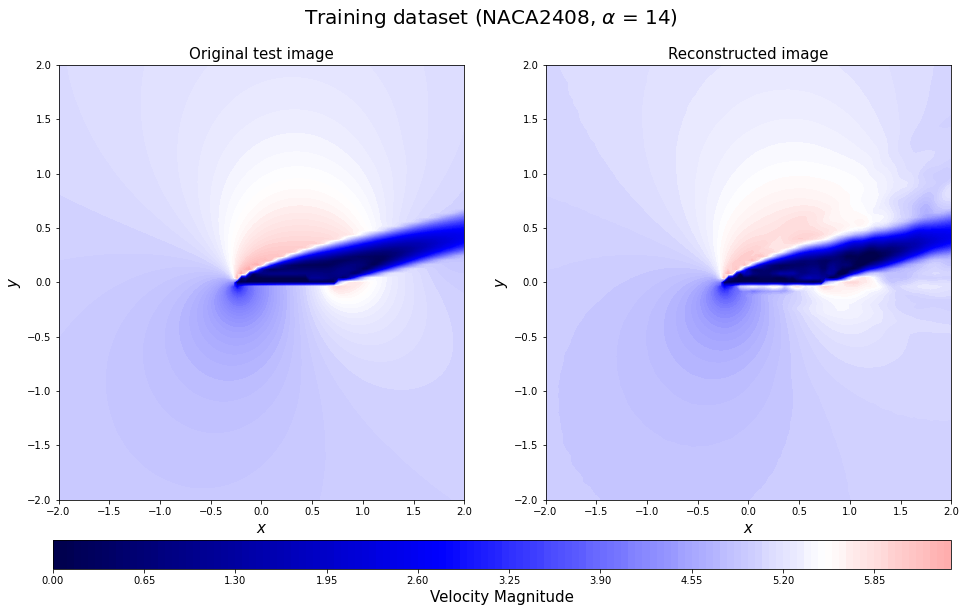

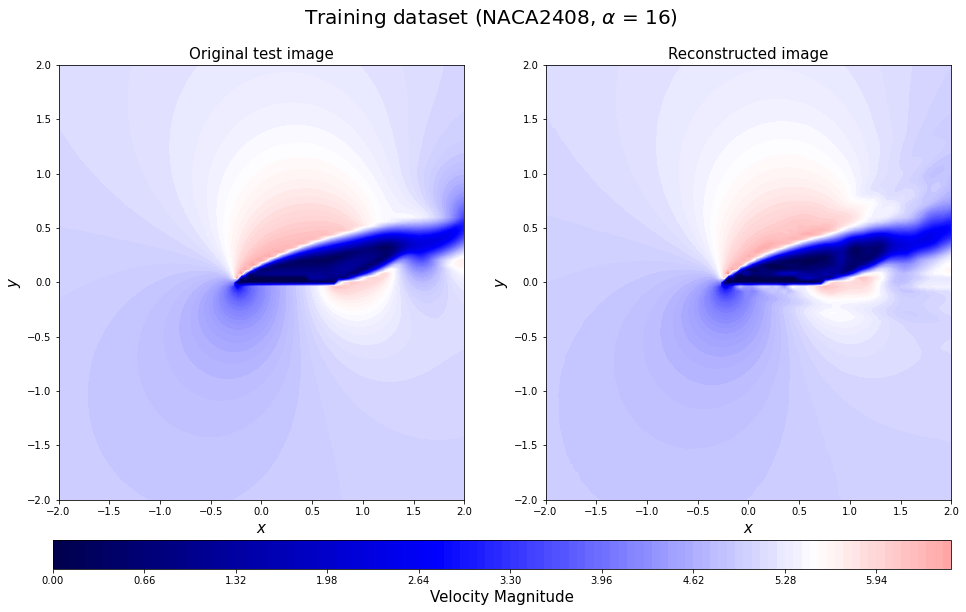

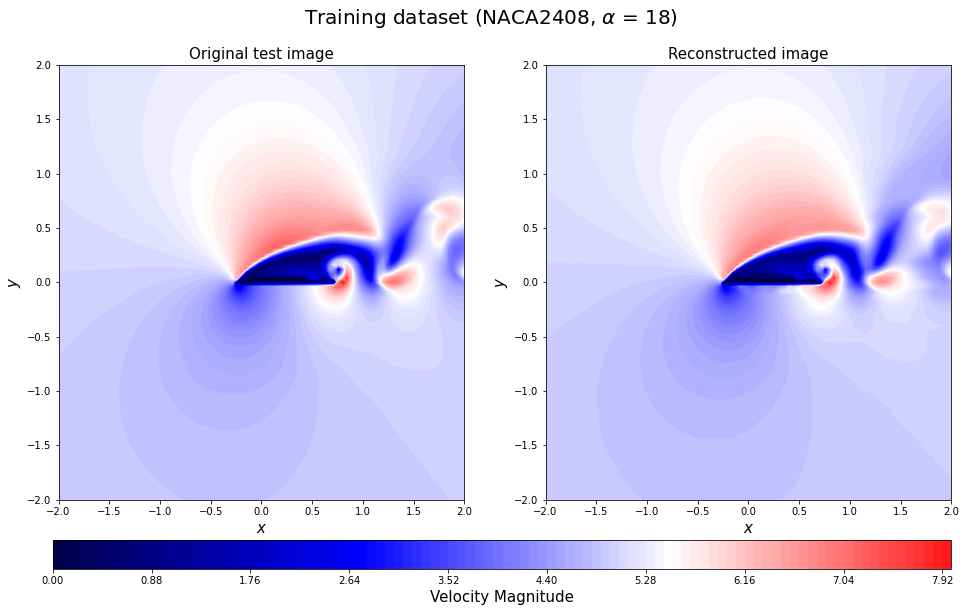

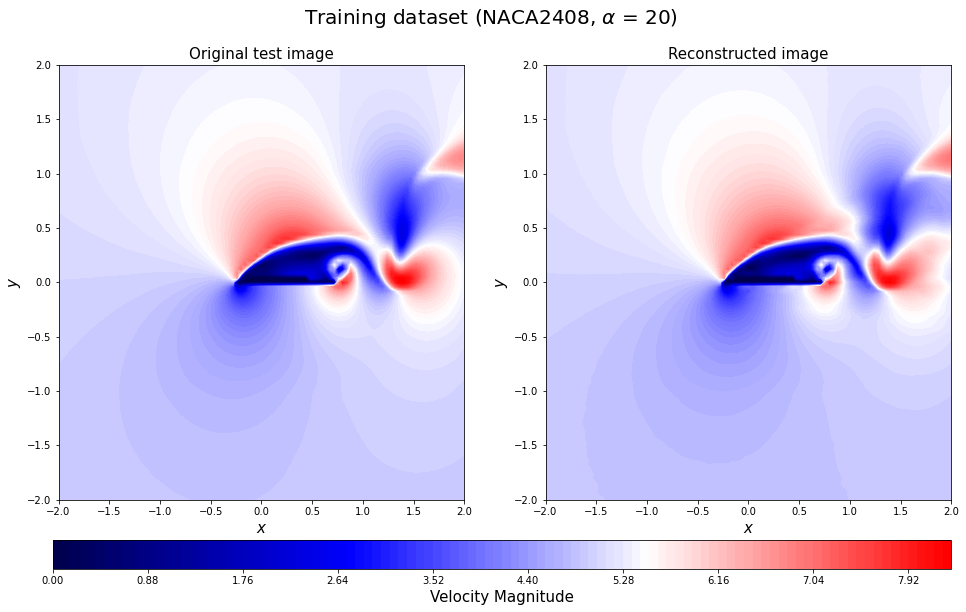

In [63]:
for c in range(0,16):
    plt.figure(figsize=(16, 8))
    y_train20_rotate = y_train[20*16+c].reshape(n_grid,n_grid)
    decoded_rotate = decoded_train[20*16+c].reshape(n_grid,n_grid)

    xrange = np.linspace(-2, 2, n_grid)
    yrange = np.linspace(-2, 2, n_grid)
    xmesh, ymesh = np.meshgrid(xrange, yrange)

    ax = plt.subplot(1, 2, 1)
    a1 = plt.contourf(xmesh, ymesh, y_train20_rotate, vmin=0, vmax=11, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Original test image', fontsize=15)

    # Display reconstruction
    ax = plt.subplot(1, 2, 2)
    a2 = plt.contourf(xmesh, ymesh, decoded_rotate, vmin=0, vmax=11, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Reconstructed image', fontsize=15)
    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(a1, cax=cax, orientation="horizontal")
    cbar.set_label('Velocity Magnitude', fontsize=15)
    #cbar.set_ticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

    plt.suptitle(r'Training dataset (%s, $\alpha$ = %d)' %(np.array2string(geo_train[20*16+c])[3:-2], aa_train[20*16+c]),fontsize=20)
    plt.show()

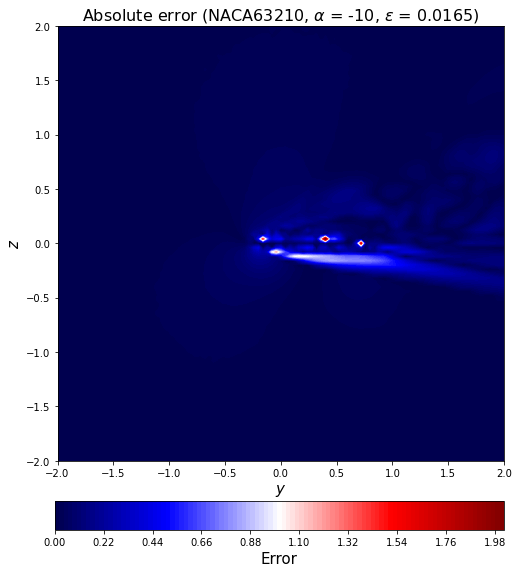

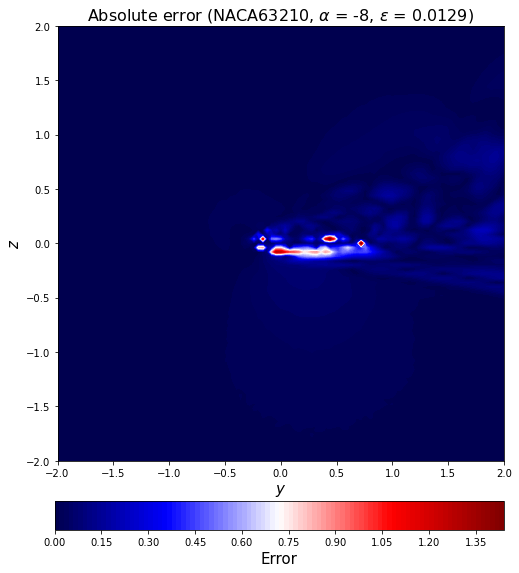

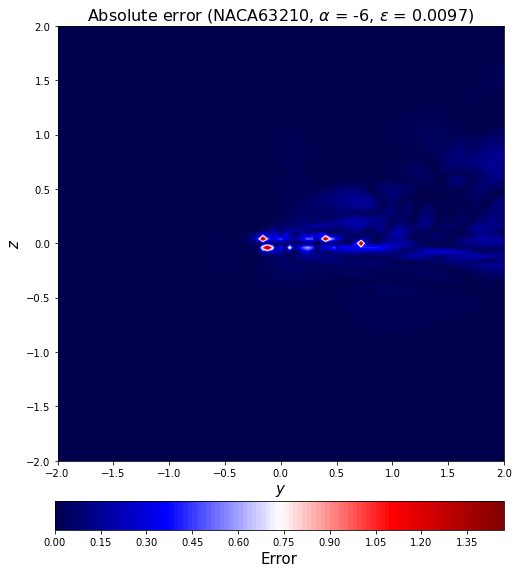

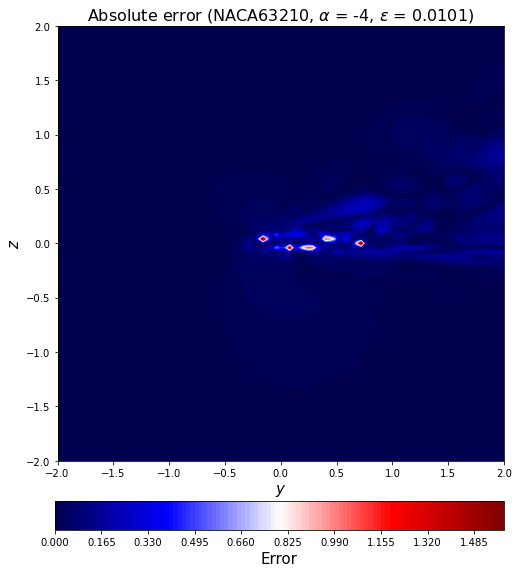

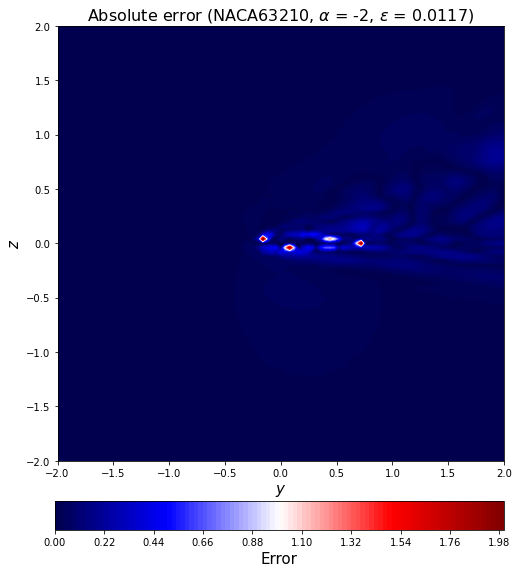

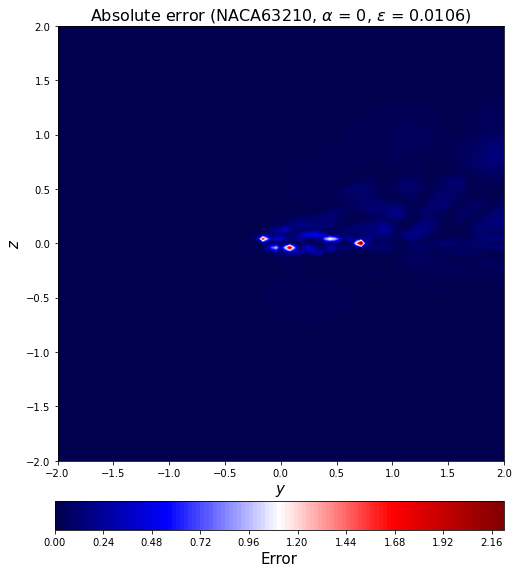

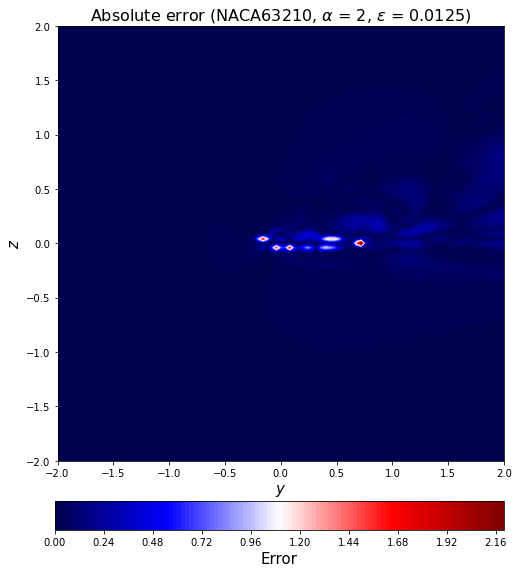

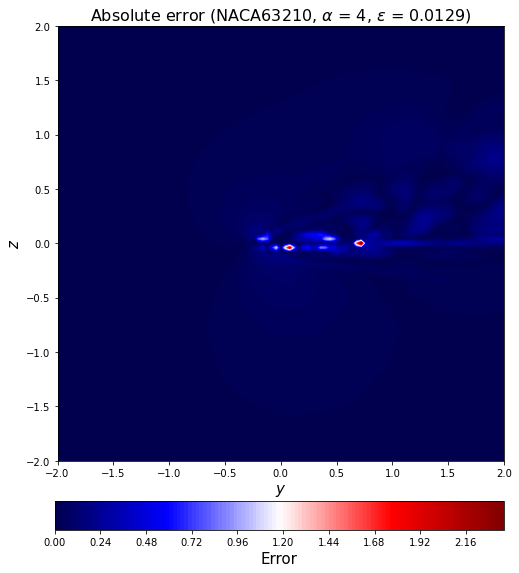

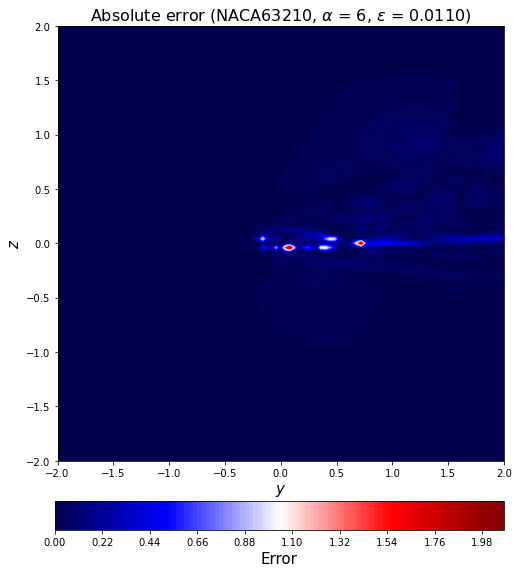

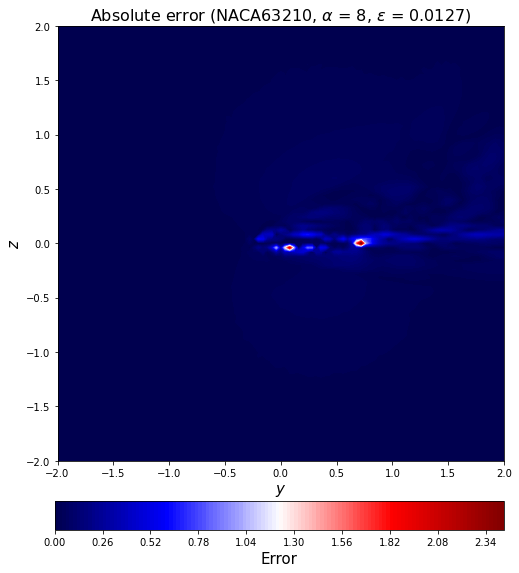

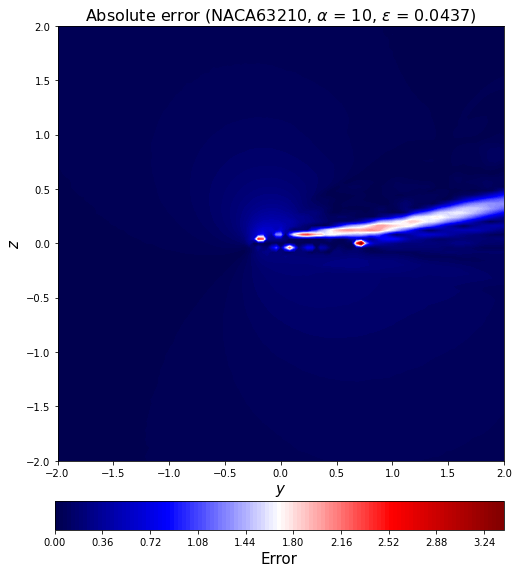

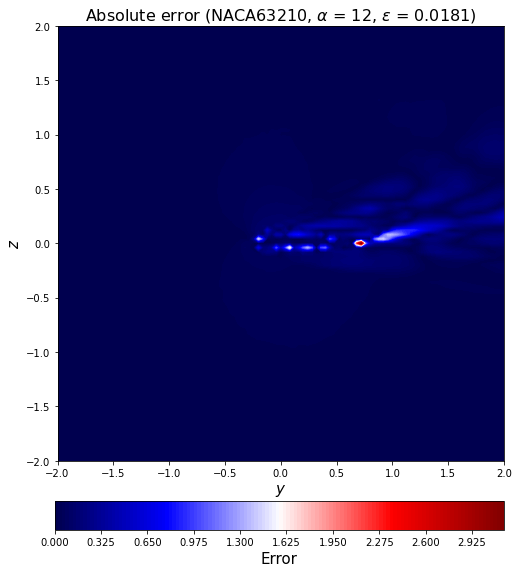

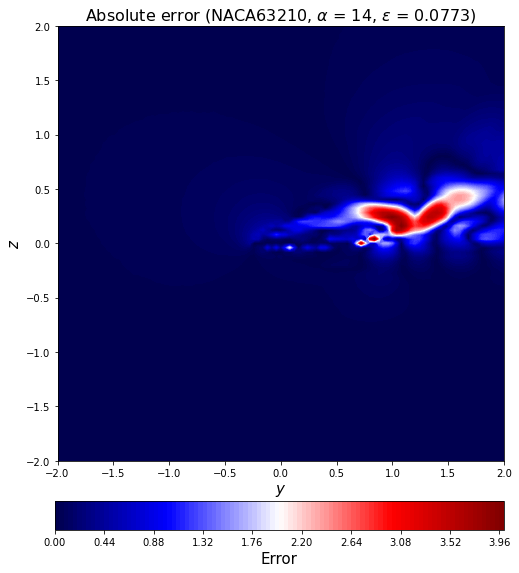

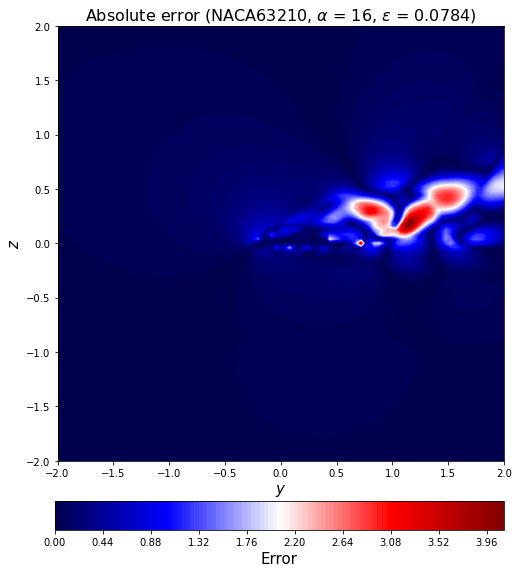

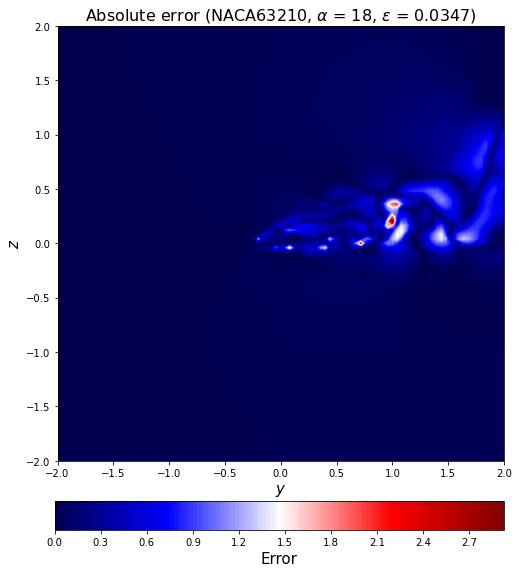

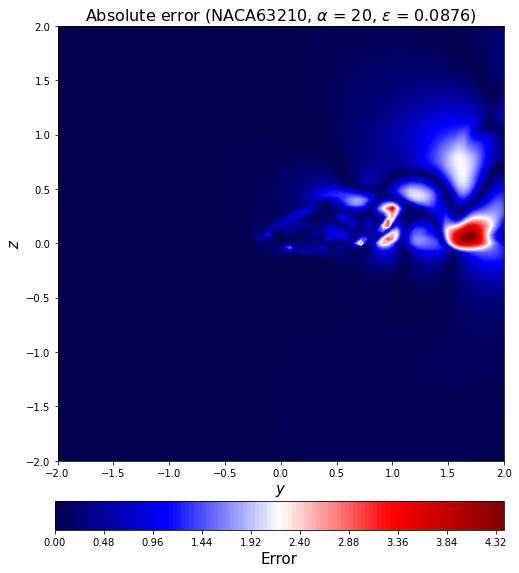

In [64]:
for c in range(0,16):
    error_test_abs2_rotate = error_test_abs[2*16+c].reshape(n_grid,n_grid)

    fig5 = plt.figure(figsize = (8, 8))
    ax5 = fig5.add_subplot(111)
    mappable = ax5.contourf(xmesh, ymesh, error_test_abs2_rotate, levels=128, cmap='seismic')
    ax5.set_title(r'Absolute error (%s, $\alpha$ = %d, $\epsilon$ = %.4f)' %(np.array2string(geo_test[2*16+c])[3:-2],
                                                                       aa_test[2*16+c], l2_error_test_list[2*16+c]), fontsize=16)
    ax5.set_xlabel('$y$', fontsize=15)
    ax5.set_ylabel('$z$', fontsize=15)

    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(mappable, cax=cax, orientation="horizontal")
    cbar.set_label('Error', fontsize=15)

    plt.show()

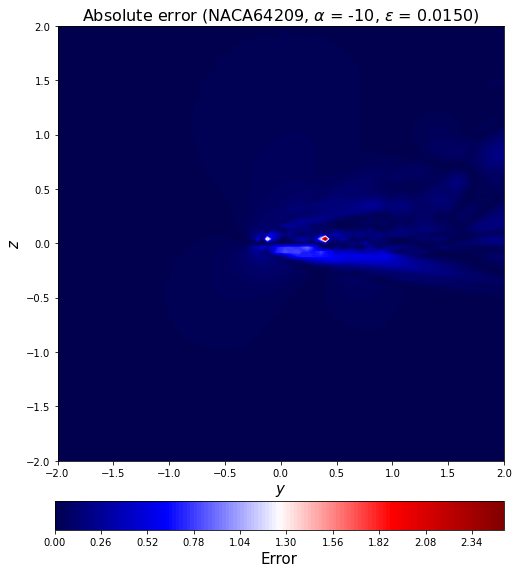

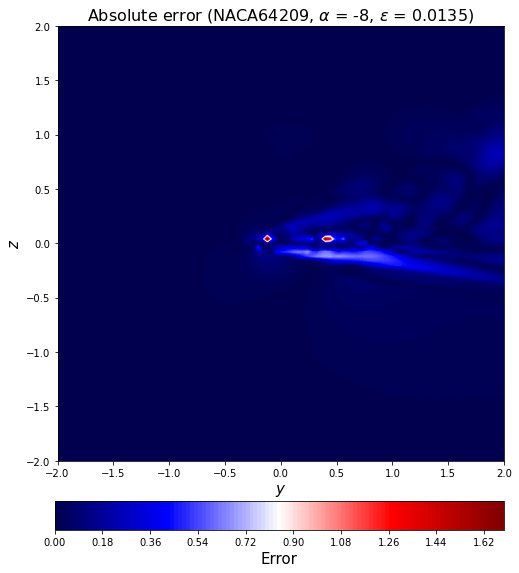

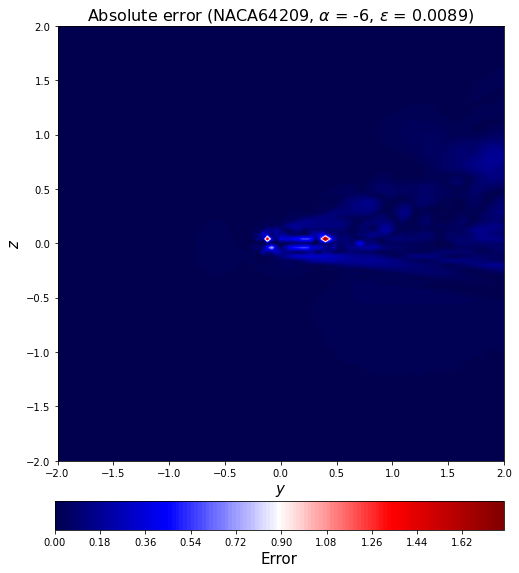

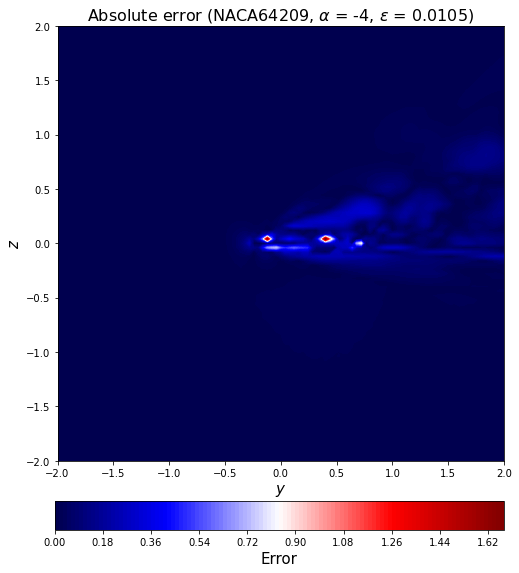

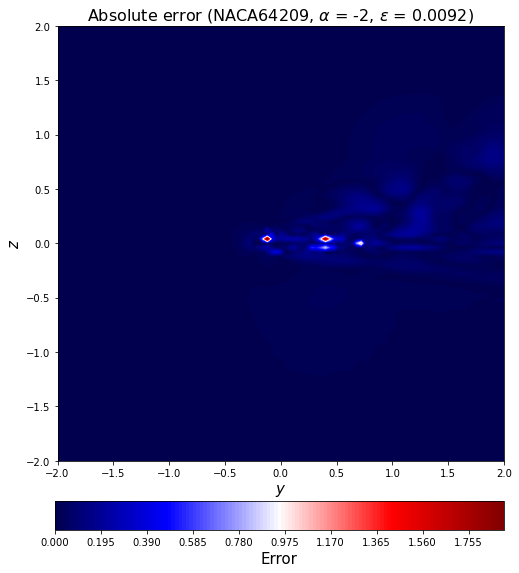

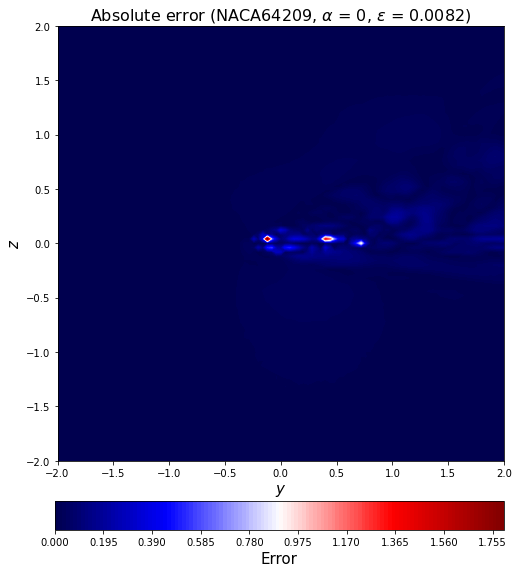

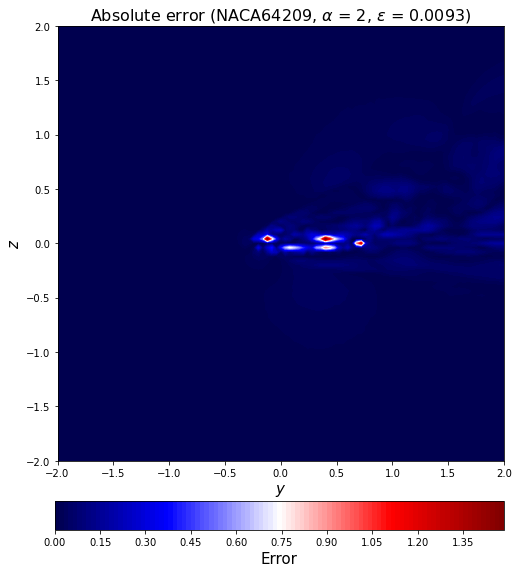

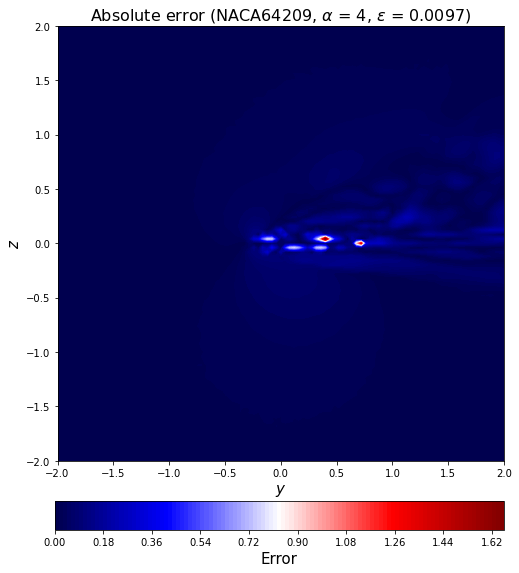

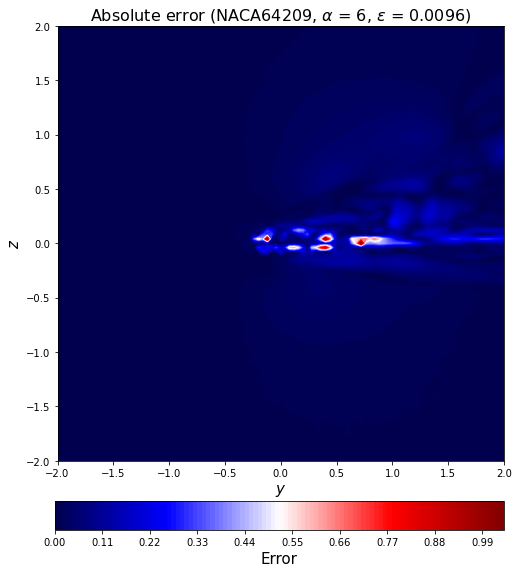

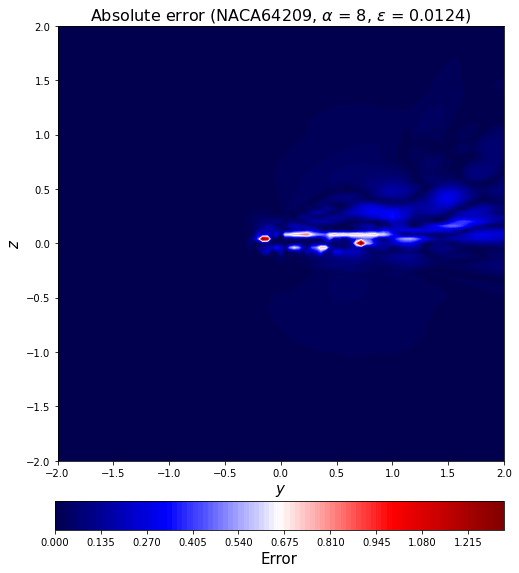

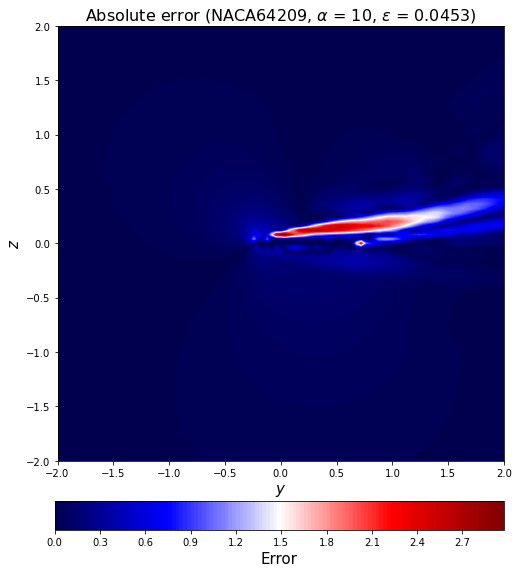

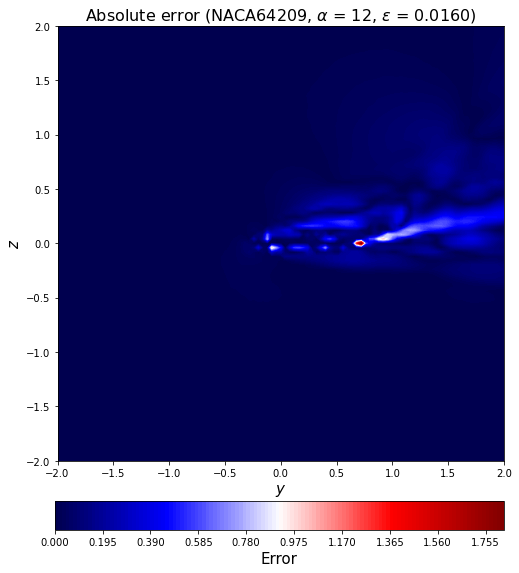

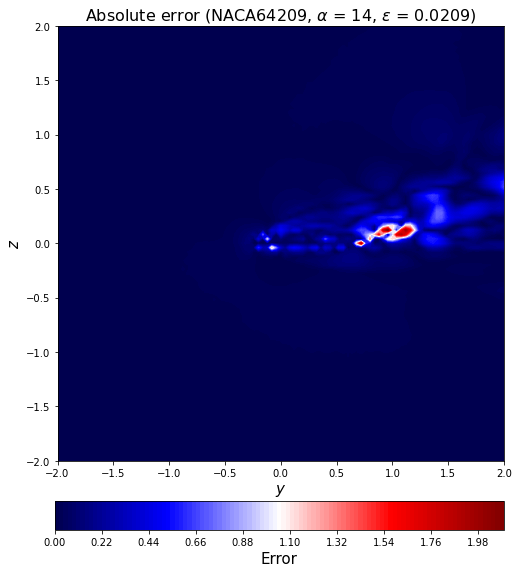

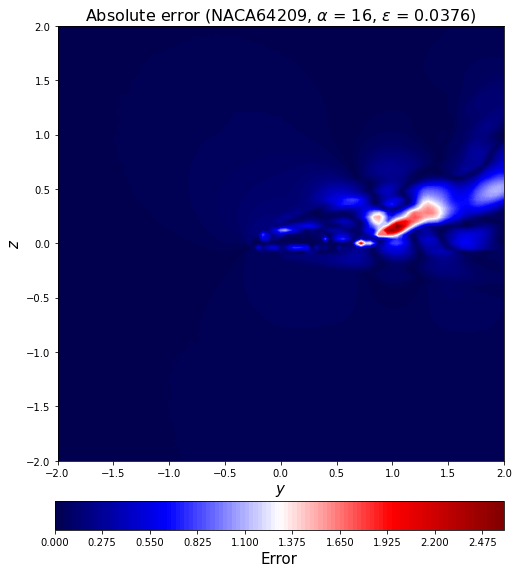

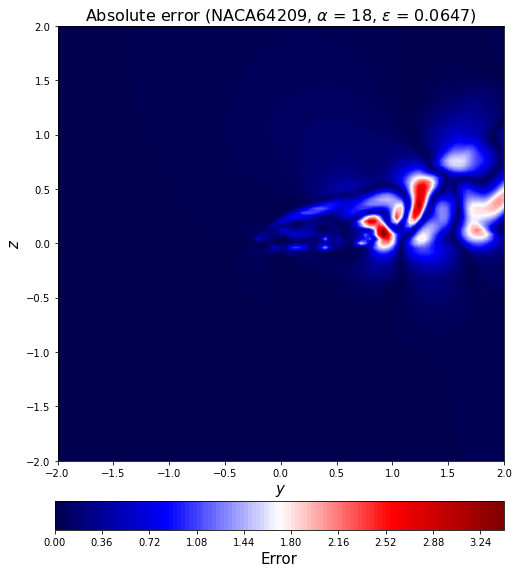

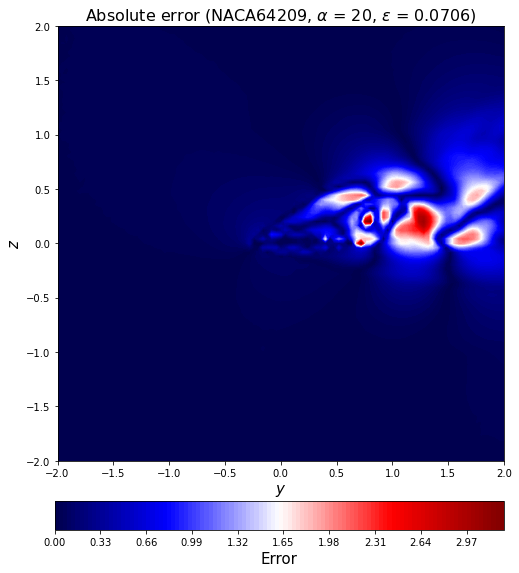

In [65]:
for c in range(0,16):
    error_test_abs2_rotate = error_test_abs[c].reshape(n_grid,n_grid)

    fig5 = plt.figure(figsize = (8, 8))
    ax5 = fig5.add_subplot(111)
    mappable = ax5.contourf(xmesh, ymesh, error_test_abs2_rotate, levels=128, cmap='seismic')
    ax5.set_title(r'Absolute error (%s, $\alpha$ = %d, $\epsilon$ = %.4f)' %(np.array2string(geo_test[c])[3:-2],
                                                                       aa_test[c], l2_error_test_list[c]), fontsize=16)
    ax5.set_xlabel('$y$', fontsize=15)
    ax5.set_ylabel('$z$', fontsize=15)

    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(mappable, cax=cax, orientation="horizontal")
    cbar.set_label('Error', fontsize=15)

    plt.show()

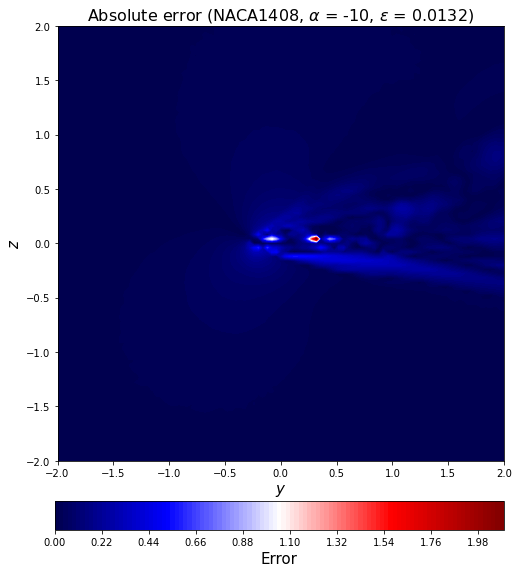

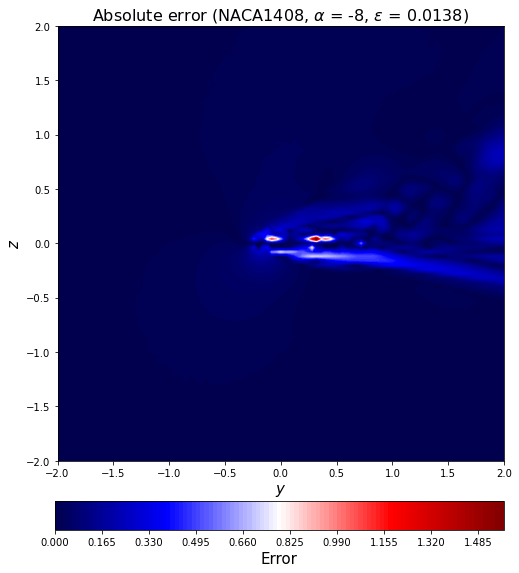

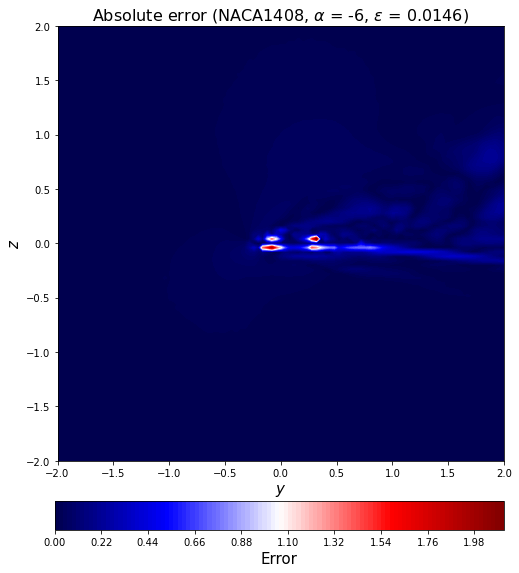

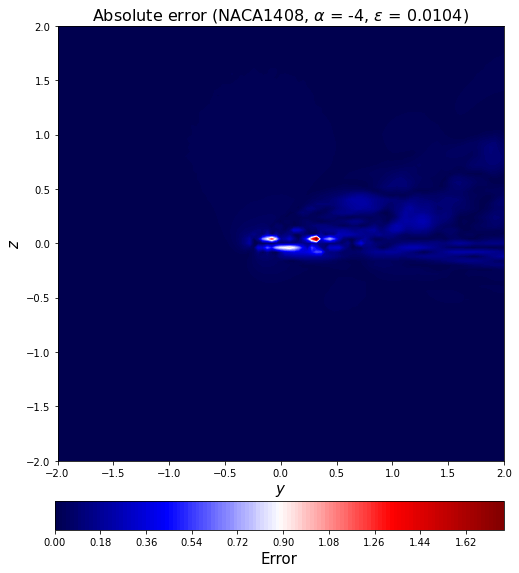

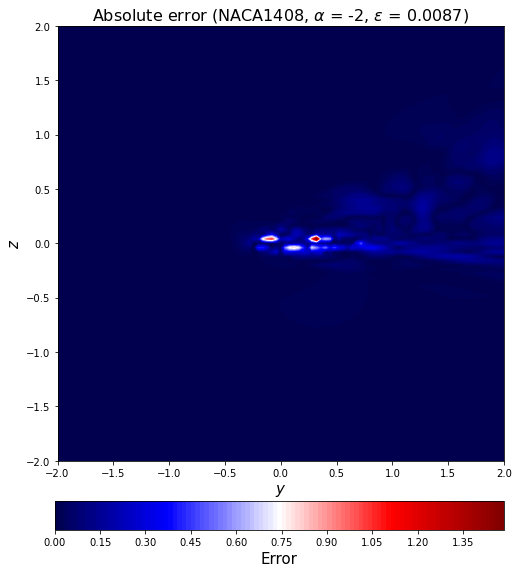

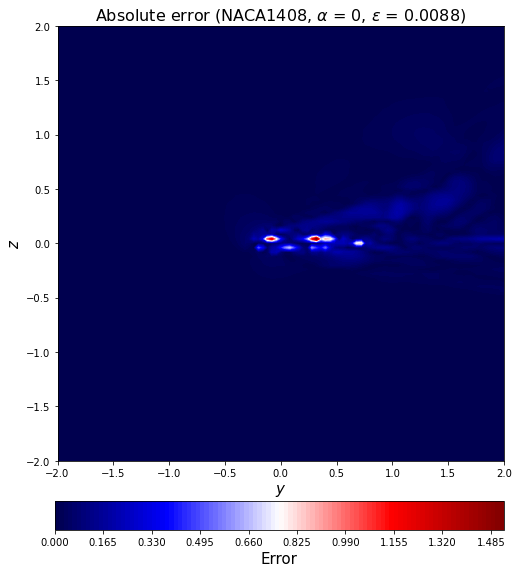

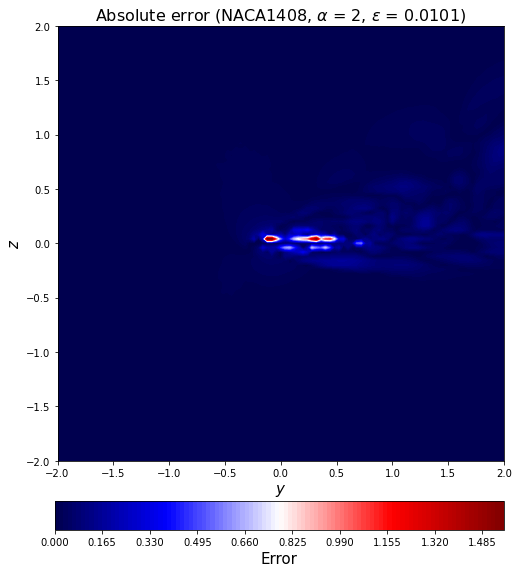

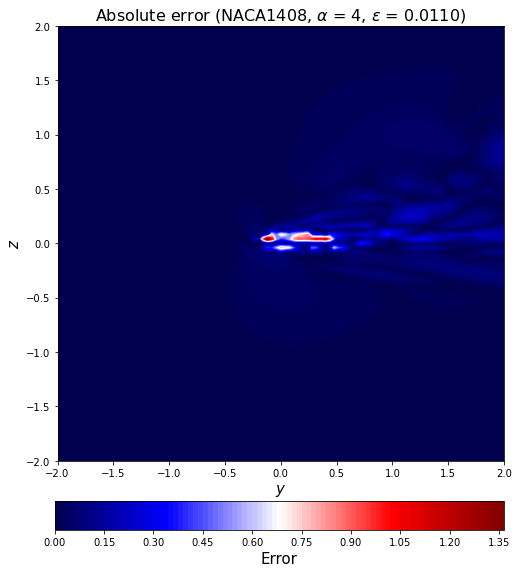

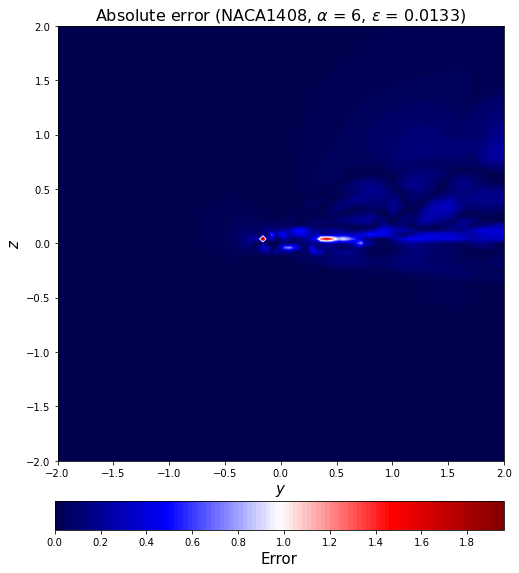

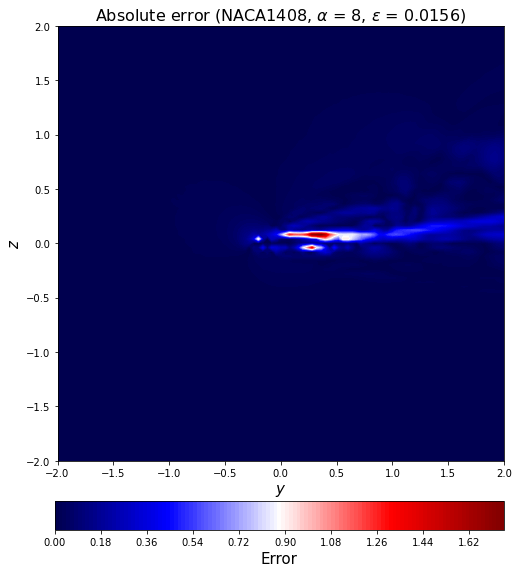

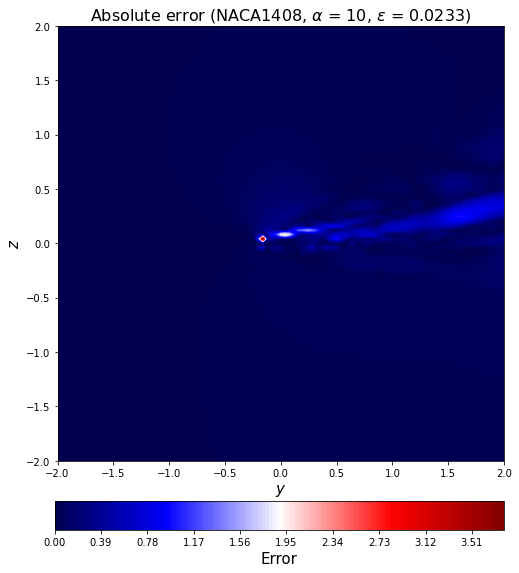

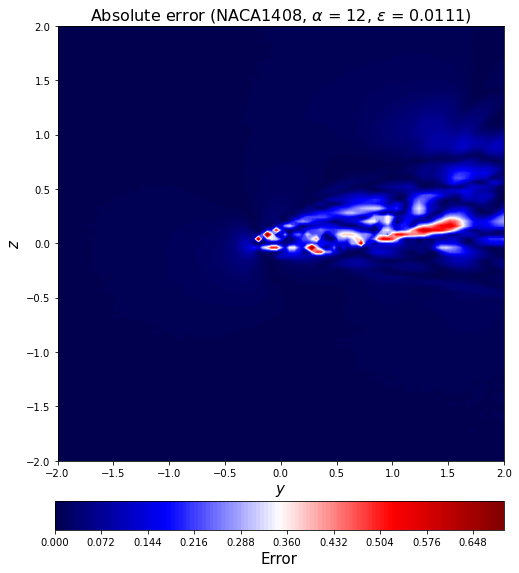

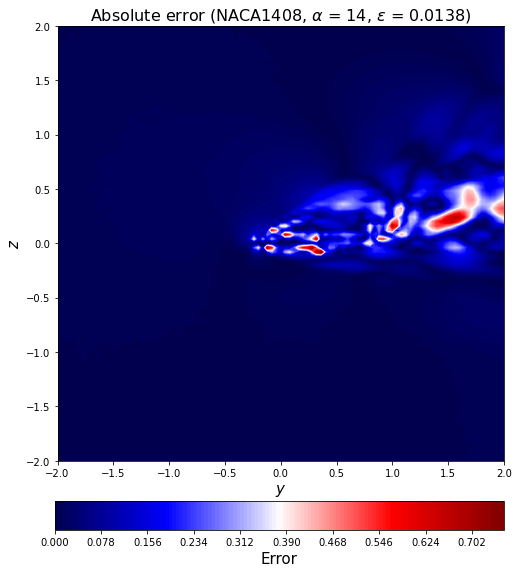

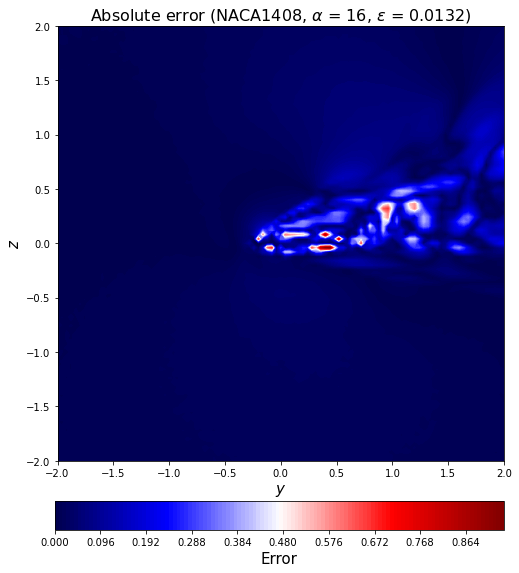

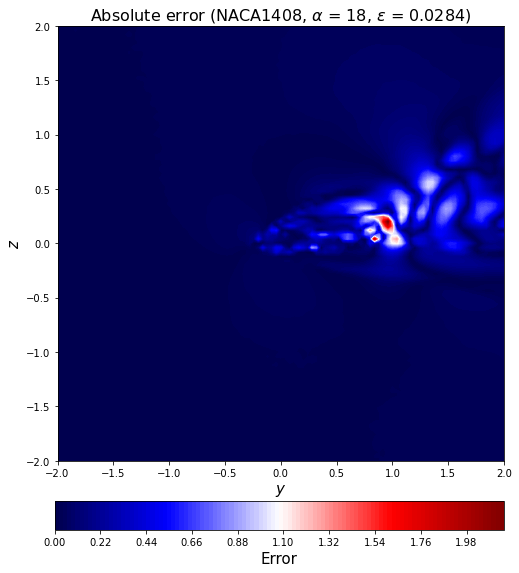

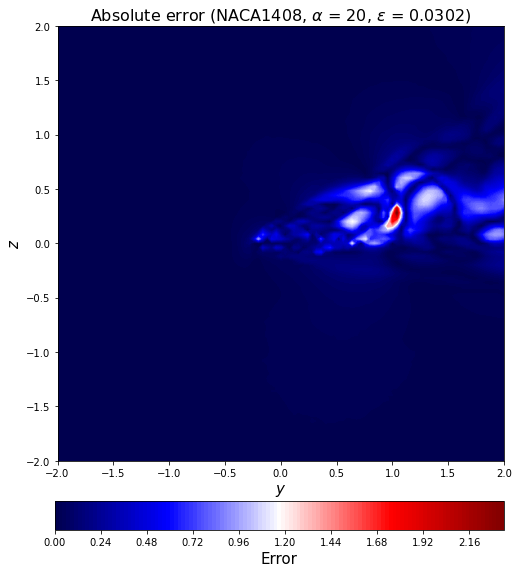

In [66]:
for c in range(0,16):
    error_train_abs2_rotate = error_train_abs[c].reshape(n_grid,n_grid)

    fig5 = plt.figure(figsize = (8, 8))
    ax5 = fig5.add_subplot(111)
    mappable = ax5.contourf(xmesh, ymesh, error_train_abs2_rotate, levels=128, cmap='seismic')
    ax5.set_title(r'Absolute error (%s, $\alpha$ = %d, $\epsilon$ = %.4f)' %(np.array2string(geo_train[c])[3:-2],
                                                                             aa_train[c], l2_error_train_list[c]), fontsize=16)
    ax5.set_xlabel('$y$', fontsize=15)
    ax5.set_ylabel('$z$', fontsize=15)

    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(mappable, cax=cax, orientation="horizontal")
    cbar.set_label('Error', fontsize=15)

    plt.show()

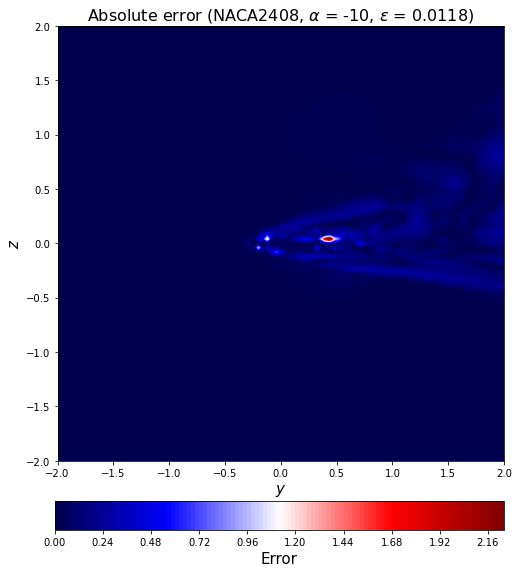

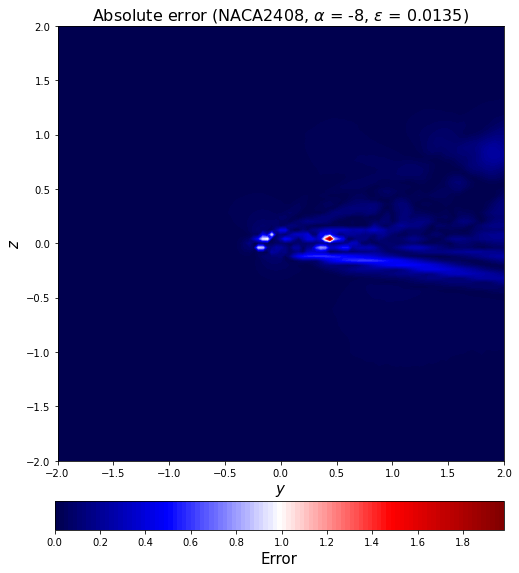

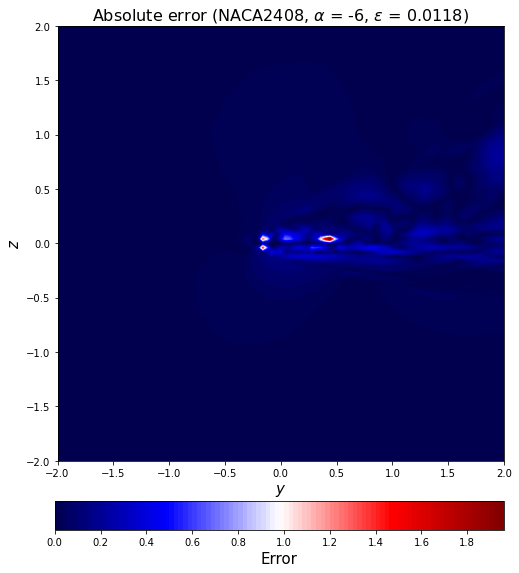

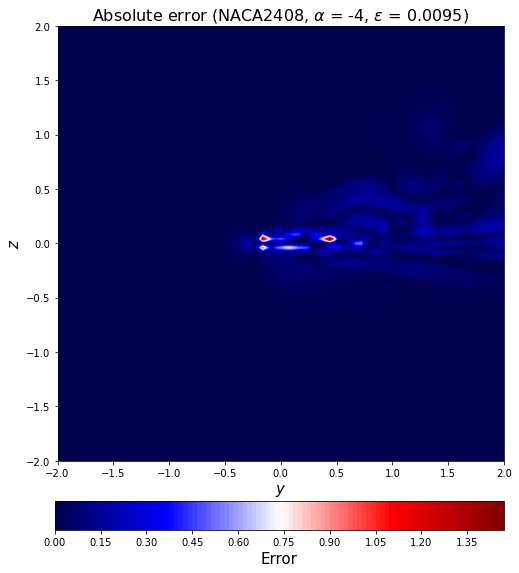

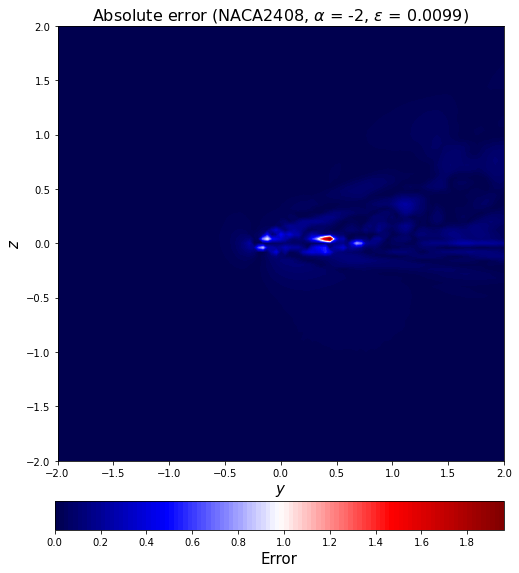

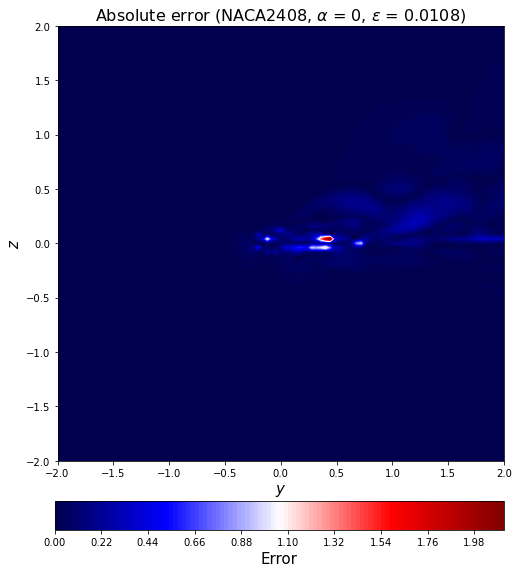

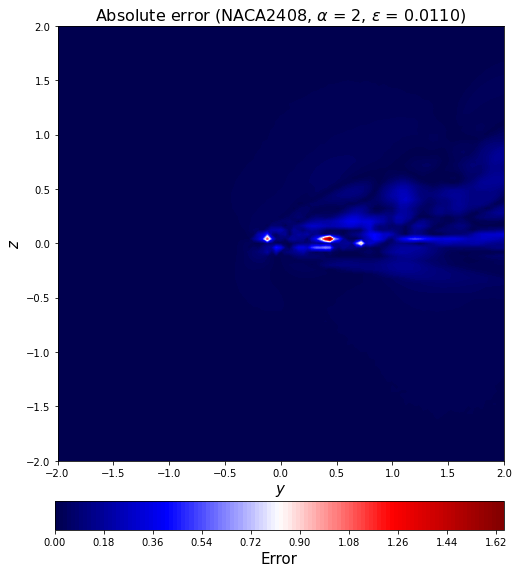

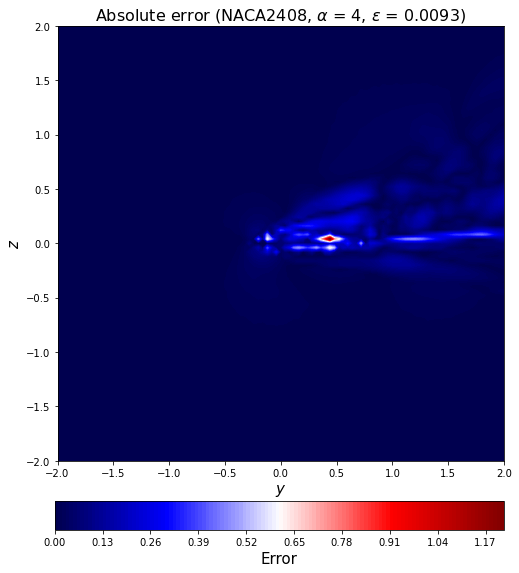

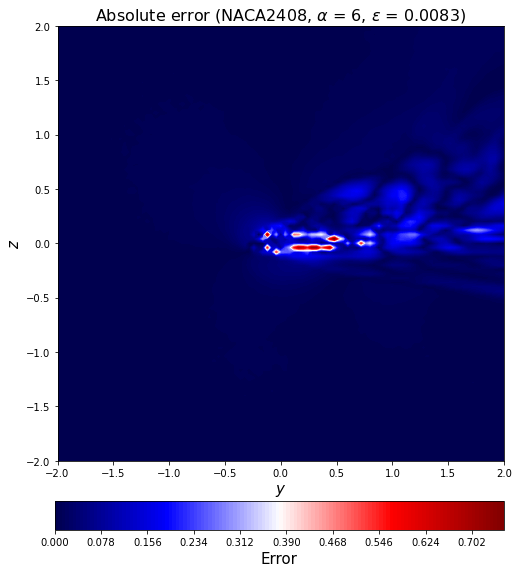

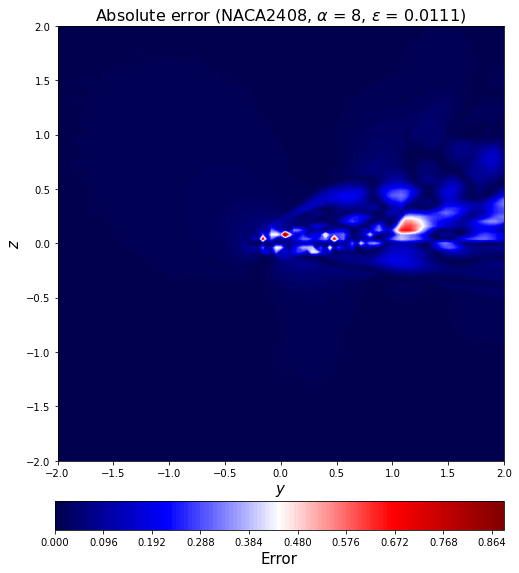

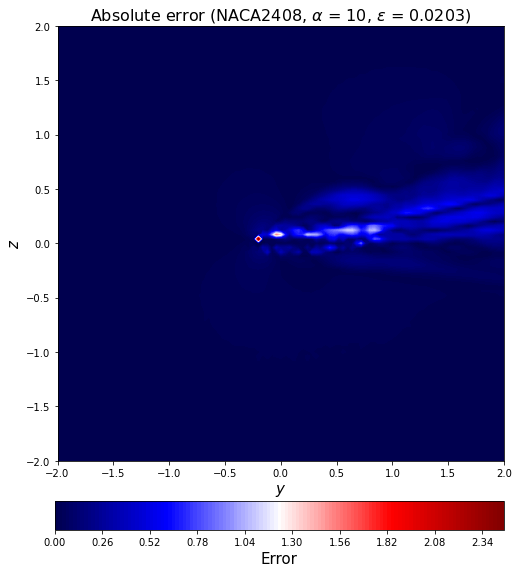

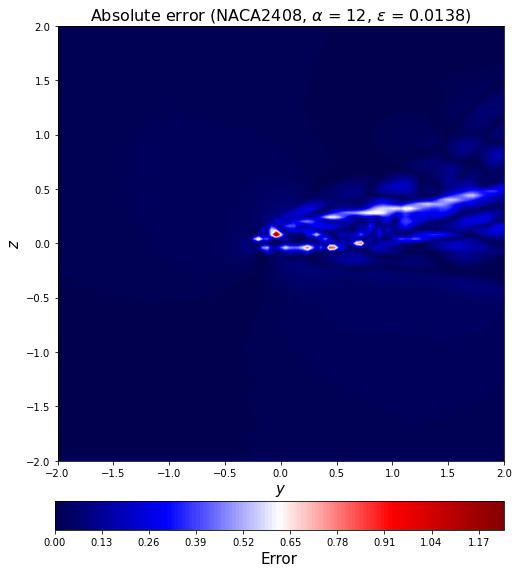

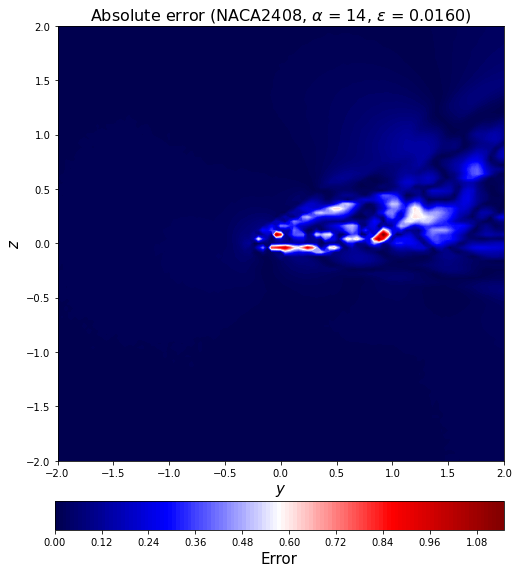

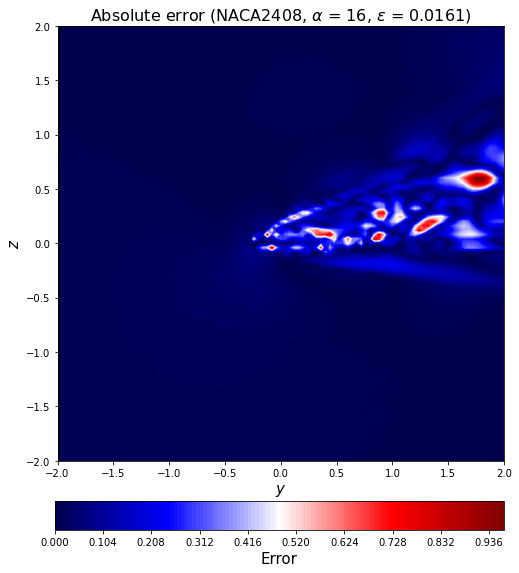

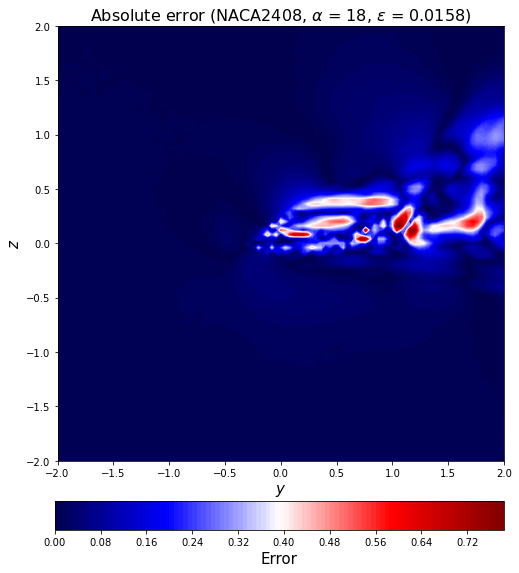

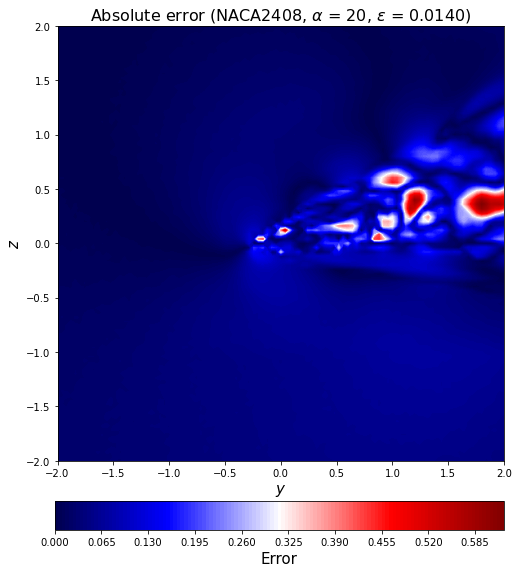

In [67]:
for c in range(0,16):
    error_train_abs2_rotate = error_train_abs[16*20+c].reshape(n_grid,n_grid)

    fig5 = plt.figure(figsize = (8, 8))
    ax5 = fig5.add_subplot(111)
    mappable = ax5.contourf(xmesh, ymesh, error_train_abs2_rotate, levels=128, cmap='seismic')
    ax5.set_title(r'Absolute error (%s, $\alpha$ = %d, $\epsilon$ = %.4f)' %(np.array2string(geo_train[16*20+c])[3:-2],
                                                                             aa_train[16*20+c], l2_error_train_list[16*20+c]),fontsize=16)
    ax5.set_xlabel('$y$', fontsize=15)
    ax5.set_ylabel('$z$', fontsize=15)

    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(mappable, cax=cax, orientation="horizontal")
    cbar.set_label('Error', fontsize=15)

    plt.show()

In [68]:
file_name = origin_data + "\\AirfoilIndexList.xlsx"
airfoilName_df = pd.read_excel(file_name)
geometry_orig2 = airfoilName_df.iloc[:, 1].values

In [69]:
geometry = geometry.reshape((133, 16, 1))
geometry2 = np.zeros((133*16,1))
geometry2 = geometry2.astype(np.string_)
for i in geometry_orig2:
    index_ = np.where(geometry_orig2==i)
    for j in range(0,16):
        geometry2[16*index_[0]+j,:] = np.asarray(i)

In [70]:
geometry2 = geometry2.reshape((133, 16, 1))

In [71]:
x_train, x_test, geo_train, geo_test, geo_train2, geo_test2 = train_test_split(1-image_np.reshape((133, 16, 100, 100))/1000, geometry, geometry2, test_size=0.05, random_state=1)

In [72]:
geo_train2 = geo_train2.reshape((geo_train.shape[0]*geo_train.shape[1], geo_train.shape[2]))
geo_test2 = geo_test2.reshape((geo_test.shape[0]*geo_test.shape[1], geo_test.shape[2]))